# Introduction

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np   #array expression
import pandas as pd  #read input
import seaborn as sns  #visualisation 
import matplotlib.pyplot as plt   #creating graph
%matplotlib inline

import plotly.express as px                  #comaprison graph
from IPython.display import Image
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from scipy.stats import uniform
import pickle
import xgboost as xgb

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.21.5
pandas version :  1.4.4
seaborn version :  0.11.2


# Load and Describe Data

## Load Data

In [2]:
data = pd.read_csv("startup data.csv")
print('There are', str(len(data)), 'rows of data in this dataset')
print('There are', str(data.shape[1]), 'features in this dataset')
data.head(5)

There are 923 rows of data in this dataset
There are 49 features in this dataset


Unnamed: 0 state_code   latitude   longitude zip_code       id  \
0        1005         CA  42.358880  -71.056820    92101   c:6669   
1         204         CA  37.238916 -121.973718    95032  c:16283   
2        1001         CA  32.901049 -117.192656    92121  c:65620   
3         738         CA  37.320309 -122.050040    95014  c:42668   
4        1002         CA  37.779281 -122.419236    94105  c:65806   

            city              Unnamed: 6               name  labels  ...  \
0      San Diego                     NaN        Bandsintown       1  ...   
1      Los Gatos                     NaN          TriCipher       1  ...   
2      San Diego      San Diego CA 92121              Plixi       1  ...   
3      Cupertino      Cupertino CA 95014  Solidcore Systems       1  ...   
4  San Francisco  San Francisco CA 94105     Inhale Digital       0  ...   

  object_id has_VC has_angel has_roundA  has_roundB  has_roundC  has_roundD  \
0    c:6669      0         1          0           0           0           0   
1   c:16283      1         0          0           1           1           1   
2   c:65620      0         0          1           0           0           0   
3   c:42668      0         0          0           1           1           1   
4   c:65806      1         1          0           0           0           0   

   avg_participants  is_top500    status  
0            1.0000          0  acquired  
1            4.7500          1  acquired  
2            4.0000          1  acquired  
3            3.3333          1  acquired  
4            1.0000          1    closed  

[5 rows x 49 columns]

In [3]:
data['status'].value_counts()

acquired    597
closed      326
Name: status, dtype: int64

In [4]:
acquired = data[data['status']=='acquired']
closed = data[data['status']=='closed']

In [5]:
print('1. The percentage of successed startup are ' + str(round((len(acquired)/len(data))*100,2)) + '%')
print('2. The percentage of failed startup are ' + str(round((len(closed)/len(data))*100,2)) + '%')

1. The percentage of successed startup are 64.68%
2. The percentage of failed startup are 35.32%


## Describe Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

# Data Understanding: Exploratory Data Analysis (EDA)

In [7]:
# assign the categorical data into cats object
cats = ['state_code', 'zip_code', 'id', 'city', 'Unnamed: 6', 
        'name', 'founded_at', 'closed_at', 'first_funding_at', 
        'last_funding_at','state_code.1', 'category_code', 'object_id', 
        'status']

# assign the numerical data into nums object
nums = ['Unnamed: 0', 'latitude', 'longitude', 'labels', 'age_first_funding_year', 
        'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 
        'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 
        'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 
        'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
        'has_roundC', 'has_roundD', 'avg_participants', 'is_top500']

#without one hot encoding features
wo_onehot = ['Unnamed: 0', 'latitude', 'longitude', 'labels', 'age_first_funding_year', 
             'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 
             'relationships', 'funding_rounds', 'funding_total_usd', 'milestones',
             'avg_participants', 'is_top500' ]

### Statistical Numerical Data

In [8]:
data[wo_onehot].describe()

Unnamed: 0    latitude   longitude      labels  \
count   923.000000  923.000000  923.000000  923.000000   
mean    572.297941   38.517442 -103.539212    0.646804   
std     333.585431    3.741497   22.394167    0.478222   
min       1.000000   25.752358 -122.756956    0.000000   
25%     283.500000   37.388869 -122.198732    0.000000   
50%     577.000000   37.779281 -118.374037    1.000000   
75%     866.500000   40.730646  -77.214731    1.000000   
max    1153.000000   59.335232   18.057121    1.000000   

       age_first_funding_year  age_last_funding_year  \
count              923.000000             923.000000   
mean                 2.235630               3.931456   
std                  2.510449               2.967910   
min                 -9.046600              -9.046600   
25%                  0.576700               1.669850   
50%                  1.446600               3.528800   
75%                  3.575350               5.560250   
max                 21.895900              21.895900   

       age_first_milestone_year  age_last_milestone_year  relationships  \
count                771.000000               771.000000     923.000000   
mean                   3.055353                 4.754423       7.710726   
std                    2.977057                 3.212107       7.265776   
min                  -14.169900                -7.005500       0.000000   
25%                    1.000000                 2.411000       3.000000   
50%                    2.520500                 4.476700       5.000000   
75%                    4.686300                 6.753400      10.000000   
max                   24.684900                24.684900      63.000000   

       funding_rounds  funding_total_usd  milestones  avg_participants  \
count      923.000000       9.230000e+02  923.000000        923.000000   
mean         2.310943       2.541975e+07    1.841820          2.838586   
std          1.390922       1.896344e+08    1.322632          1.874601   
min          1.000000       1.100000e+04    0.000000          1.000000   
25%          1.000000       2.725000e+06    1.000000          1.500000   
50%          2.000000       1.000000e+07    2.000000          2.500000   
75%          3.000000       2.472500e+07    3.000000          3.800000   
max         10.000000       5.700000e+09    8.000000         16.000000   

        is_top500  
count  923.000000  
mean     0.809317  
std      0.393052  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000

### Statistical Categorical Data

In [9]:
data[cats].describe()

state_code zip_code       id           city              Unnamed: 6  \
count         923      923      923            923                     430   
unique         35      382      922            221                     252   
top            CA    94107  c:28482  San Francisco  San Francisco CA 94105   
freq          488       30        2            128                      12   

                   name founded_at closed_at first_funding_at last_funding_at  \
count               923        923       335              923             923   
unique              922        217       202              585             680   
top     Redwood Systems   1/1/2003  6/1/2013         1/1/2008        1/1/2008   
freq                  2         55        25               18              11   

       state_code.1 category_code object_id    status  
count           922           923       923       923  
unique           35            35       922         2  
top              CA      software   c:28482  acquired  
freq            487           153         2       597

## Check Missing Values

In [10]:
# assign features with missing value into data_missing object
data_missing = data.isnull().sum().reset_index()
data_missing.columns = ['feature','missing_value']
data_missing = data_missing[data_missing['missing_value'] > 0].reset_index(drop=True)
data_missing['percentage'] = (data_missing['missing_value']/len(data))*100
data_missing

feature  missing_value  percentage
0                Unnamed: 6            493   53.412784
1                 closed_at            588   63.705309
2  age_first_milestone_year            152   16.468039
3   age_last_milestone_year            152   16.468039
4              state_code.1              1    0.108342

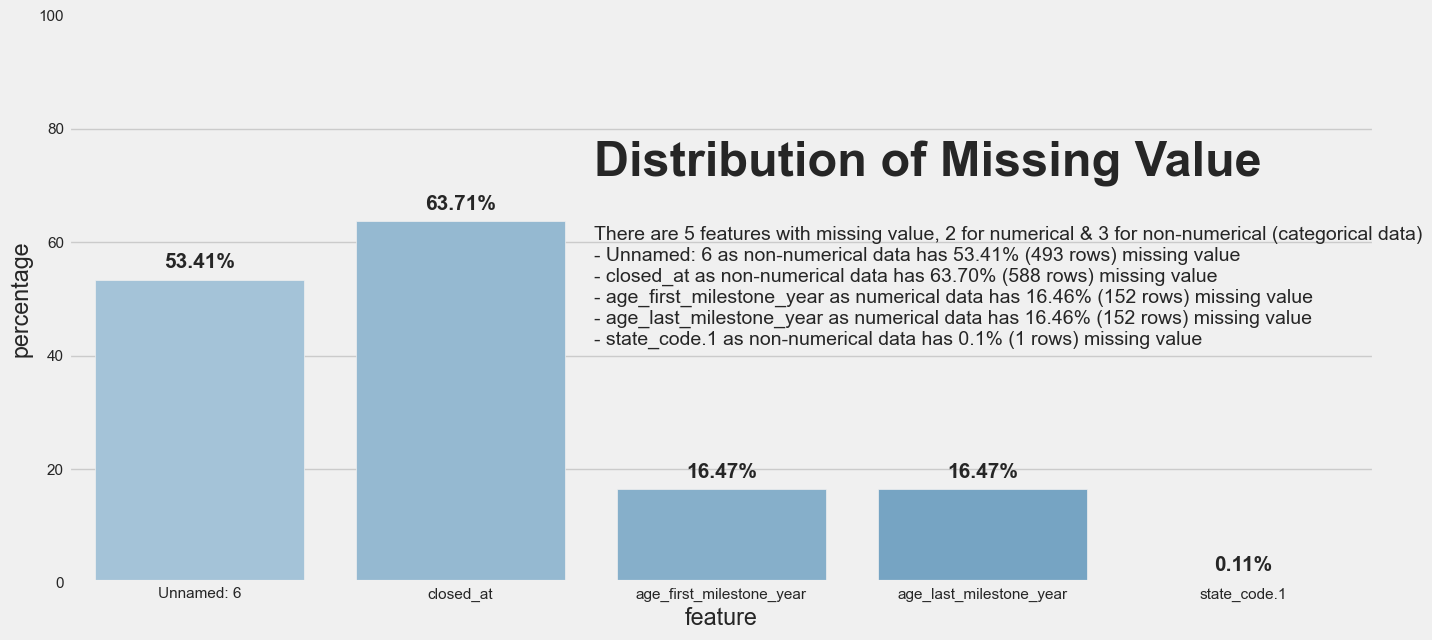

In [11]:
fig, ax = plt.subplots(figsize = (15,7))

mvalue_plot = sns.barplot(x='feature', y='percentage', data=data_missing,
           palette = sns.color_palette('Blues_d', n_colors = 13, desat = 1))

ax.set_ylim(0,100)

for p in mvalue_plot.patches:
    height = p.get_height()
    mvalue_plot.text(x = p.get_x() + (p.get_width()/2),
                y = height + 2,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center', fontsize = 15, fontweight='bold')

title = '''Distribution of Missing Value'''
fig.text(x=0.43, y=0.65, s = title, fontsize = 35, weight = 'bold')

text = '''
There are 5 features with missing value, 2 for numerical & 3 for non-numerical (categorical data)
- Unnamed: 6 as non-numerical data has 53.41% (493 rows) missing value
- closed_at as non-numerical data has 63.70% (588 rows) missing value
- age_first_milestone_year as numerical data has 16.46% (152 rows) missing value
- age_last_milestone_year as numerical data has 16.46% (152 rows) missing value
- state_code.1 as non-numerical data has 0.1% (1 rows) missing value

'''
fig.text(x=0.43, y=0.35, s = text, fontsize=14);

#plt.savefig('fig/Distribution of Missing Value.png', tight_box=True)

## Check Duplicated Data

In [12]:
data.duplicated().sum()

0

## Drop Columns

In [13]:
data_clean = data.drop(['Unnamed: 0', 'Unnamed: 6', 'id', 'object_id', 'latitude', 'longitude',
                       'zip_code', 'state_code.1', 'status'], axis=1)

## Fix Missing Values

In [14]:
# assign features with missing value into data_missing1 object
data_missing1 = data_clean.isnull().sum().reset_index()
data_missing1.columns = ['feature','missing_value']
data_missing1 = data_missing1[data_missing1['missing_value'] > 0].reset_index(drop=True)
data_missing1['percentage'] = (data_missing1['missing_value']/len(data))*100
data_missing1

feature  missing_value  percentage
0                 closed_at            588   63.705309
1  age_first_milestone_year            152   16.468039
2   age_last_milestone_year            152   16.468039

In [15]:
# change column to date type
data_clean.founded_at=pd.to_datetime(data_clean.founded_at)
data_clean.closed_at=pd.to_datetime(data_clean.closed_at)
data_clean.first_funding_at=pd.to_datetime(data_clean.first_funding_at)
data_clean.last_funding_at=pd.to_datetime(data_clean.last_funding_at)

data_clean.head(3)

state_code       city         name  labels founded_at closed_at  \
0         CA  San Diego  Bandsintown       1 2007-01-01       NaT   
1         CA  Los Gatos    TriCipher       1 2000-01-01       NaT   
2         CA  San Diego        Plixi       1 2009-03-18       NaT   

  first_funding_at last_funding_at  age_first_funding_year  \
0       2009-04-01      2010-01-01                  2.2493   
1       2005-02-14      2009-12-28                  5.1260   
2       2010-03-30      2010-03-30                  1.0329   

   age_last_funding_year  ...  is_consulting  is_othercategory  has_VC  \
0                 3.0027  ...              0                 1       0   
1                 9.9973  ...              0                 0       1   
2                 1.0329  ...              0                 0       0   

   has_angel  has_roundA  has_roundB  has_roundC  has_roundD  \
0          1           0           0           0           0   
1          0           0           1           1           1   
2          0           1           0           0           0   

   avg_participants  is_top500  
0              1.00          0  
1              4.75          1  
2              4.00          1  

[3 rows x 40 columns]

In [16]:
# fill missing value in closed_at with closed_at + 1 day so we know that the startup haven't been failed yet
from datetime import timedelta
data_clean['closed_at'] = data_clean['closed_at'].fillna(data_clean['closed_at'].max() + timedelta(days=1))

In [17]:
# Assign startup age in days to age column
data_clean['age'] = data_clean['closed_at'] - data_clean['founded_at']
# age from success startup
data_clean['age'].max()

Timedelta('10368 days 00:00:00')

In [18]:
data_clean['age'] = data_clean['age'].astype(str)
data_clean[['age','suffix']] = data_clean.age.str.split(" ",expand=True)
data_clean = data_clean.drop(['suffix'], axis=1)
data_clean['age'] = data_clean['age'].astype(int)

In [19]:
# we must get the absolute value of this four columns
data_clean["age_first_funding_year"]=np.abs(data_clean["age_first_funding_year"])
data_clean["age_last_funding_year"]=np.abs(data_clean["age_last_funding_year"])
data_clean["age_first_milestone_year"]=np.abs(data_clean["age_first_milestone_year"])
data_clean["age_last_milestone_year"]=np.abs(data_clean["age_last_milestone_year"])

In [20]:
data_clean.head()

state_code           city               name  labels founded_at  closed_at  \
0         CA      San Diego        Bandsintown       1 2007-01-01 2013-10-31   
1         CA      Los Gatos          TriCipher       1 2000-01-01 2013-10-31   
2         CA      San Diego              Plixi       1 2009-03-18 2013-10-31   
3         CA      Cupertino  Solidcore Systems       1 2002-01-01 2013-10-31   
4         CA  San Francisco     Inhale Digital       0 2010-08-01 2012-10-01   

  first_funding_at last_funding_at  age_first_funding_year  \
0       2009-04-01      2010-01-01                  2.2493   
1       2005-02-14      2009-12-28                  5.1260   
2       2010-03-30      2010-03-30                  1.0329   
3       2005-02-17      2007-04-25                  3.1315   
4       2010-08-01      2012-04-01                  0.0000   

   age_last_funding_year  ...  is_othercategory  has_VC  has_angel  \
0                 3.0027  ...                 1       0          1   
1                 9.9973  ...                 0       1          0   
2                 1.0329  ...                 0       0          0   
3                 5.3151  ...                 0       0          0   
4                 1.6685  ...                 0       1          1   

   has_roundA  has_roundB  has_roundC  has_roundD  avg_participants  \
0           0           0           0           0            1.0000   
1           0           1           1           1            4.7500   
2           1           0           0           0            4.0000   
3           0           1           1           1            3.3333   
4           0           0           0           0            1.0000   

   is_top500   age  
0          0  2495  
1          1  5052  
2          1  1688  
3          1  4321  
4          1   792  

[5 rows x 41 columns]

In [21]:
# for columns with missing value i will fill it by median() function
data_clean["age_first_milestone_year"].fillna((data_clean["age_first_milestone_year"].median()), inplace=True)
data_clean["age_last_milestone_year"].fillna((data_clean["age_last_milestone_year"].median()), inplace=True)

In [22]:
data_clean.isnull().sum()

state_code                  0
city                        0
name                        0
labels                      0
founded_at                  0
closed_at                   0
first_funding_at            0
last_funding_at             0
age_first_funding_year      0
age_last_funding_year       0
age_first_milestone_year    0
age_last_milestone_year     0
relationships               0
funding_rounds              0
funding_total_usd           0
milestones                  0
is_CA                       0
is_NY                       0
is_MA                       0
is_TX                       0
is_otherstate               0
category_code               0
is_software                 0
is_web                      0
is_mobile                   0
is_enterprise               0
is_advertising              0
is_gamesvideo               0
is_ecommerce                0
is_biotech                  0
is_consulting               0
is_othercategory            0
has_VC                      0
has_angel 

In [23]:
# We also simplify the total_funding_usd value
data_clean['funding_total_usd'] = data_clean['funding_total_usd']/100000

In [24]:
#assign numerical data into dat_num object
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data_clean.select_dtypes(include=numerics).columns)
print(data_clean.select_dtypes(include=numerics).shape)
data_num = data_clean.select_dtypes(include=numerics)
data_num.head(3)

Index(['labels', 'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile',
       'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
       'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC',
       'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
       'avg_participants', 'is_top500', 'age'],
      dtype='object')

(923, 33)


labels  age_first_funding_year  age_last_funding_year  \
0       1                  2.2493                 3.0027   
1       1                  5.1260                 9.9973   
2       1                  1.0329                 1.0329   

   age_first_milestone_year  age_last_milestone_year  relationships  \
0                    4.6685                   6.7041              3   
1                    7.0055                   7.0055              9   
2                    1.4575                   2.2055              5   

   funding_rounds  funding_total_usd  milestones  is_CA  ...  \
0               3               3.75           3      1  ...   
1               4             401.00           1      1  ...   
2               1              26.00           2      1  ...   

   is_othercategory  has_VC  has_angel  has_roundA  has_roundB  has_roundC  \
0                 1       0          1           0           0           0   
1                 0       1          0           0           1           1   
2                 0       0          0           1           0           0   

   has_roundD  avg_participants  is_top500   age  
0           0              1.00          0  2495  
1           1              4.75          1  5052  
2           0              4.00          1  1688  

[3 rows x 33 columns]

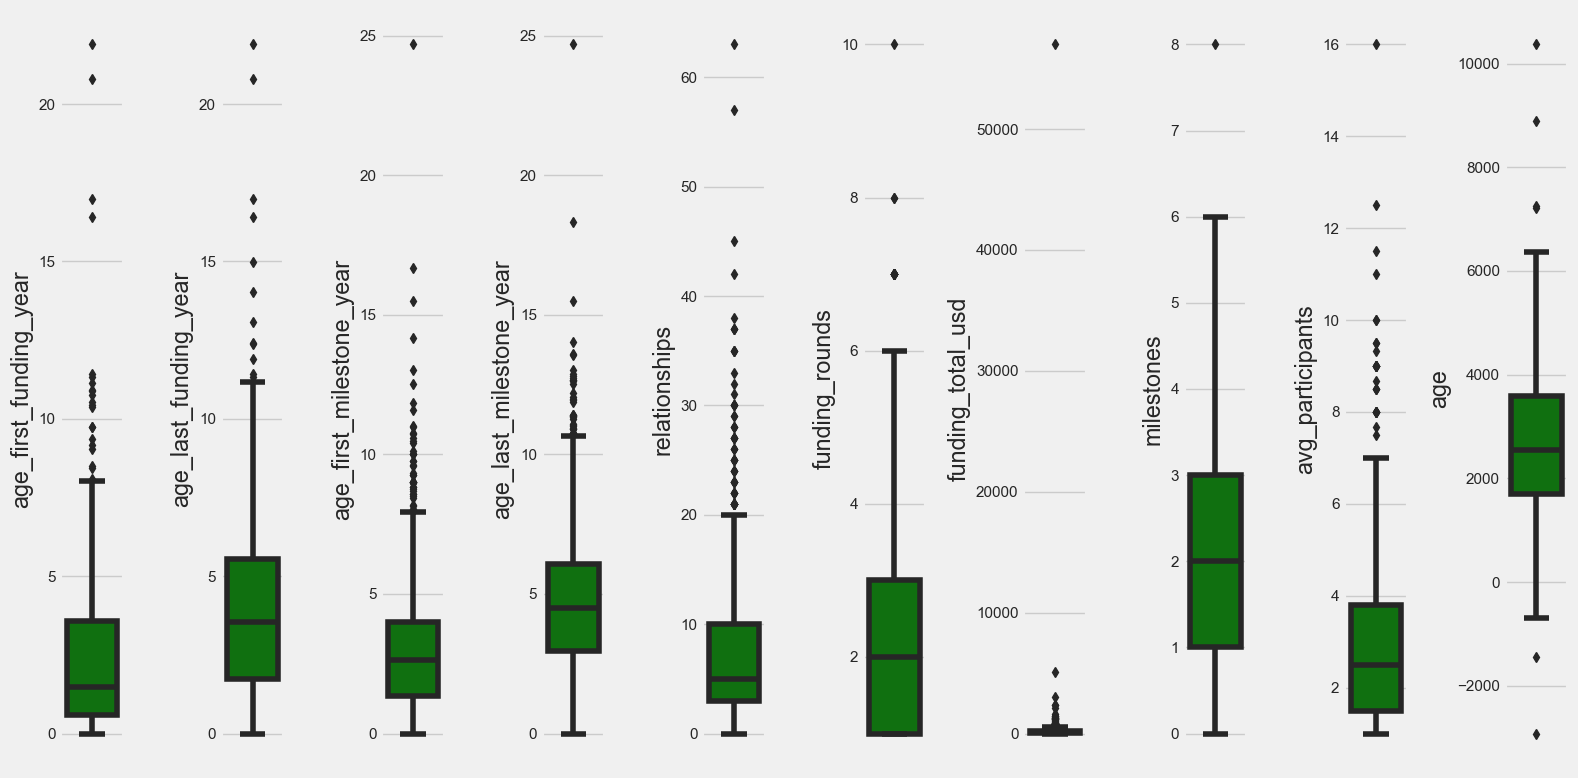

In [25]:
# look at the distribution of data with boxplot
# We only use continuous variables and exclude the boolean value
features = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
            'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd',
            'milestones', 'avg_participants', 'age']
for i in range(0, len(features)):
    plt.subplot(1, 10, i+1)
    sns.boxplot(y=data_clean[features[i]],color='green',orient='v')
    plt.tight_layout()
#plt.savefig('fig/Boxplot.png', tight_box=True)

#### Non-Numerical (Categorical)

In [26]:
# assign categorical data into data_cat object
display(data_clean.select_dtypes(include=['object']).columns)
print(data_clean.select_dtypes(include=object).shape)
data_cat = data_clean.select_dtypes(include=['object'])
data_cat.head(3)

Index(['state_code', 'city', 'name', 'category_code'], dtype='object')

(923, 4)


state_code       city         name category_code
0         CA  San Diego  Bandsintown         music
1         CA  Los Gatos    TriCipher    enterprise
2         CA  San Diego        Plixi           web

### Multivariate Analysis

#### Numerical Data

<AxesSubplot:>

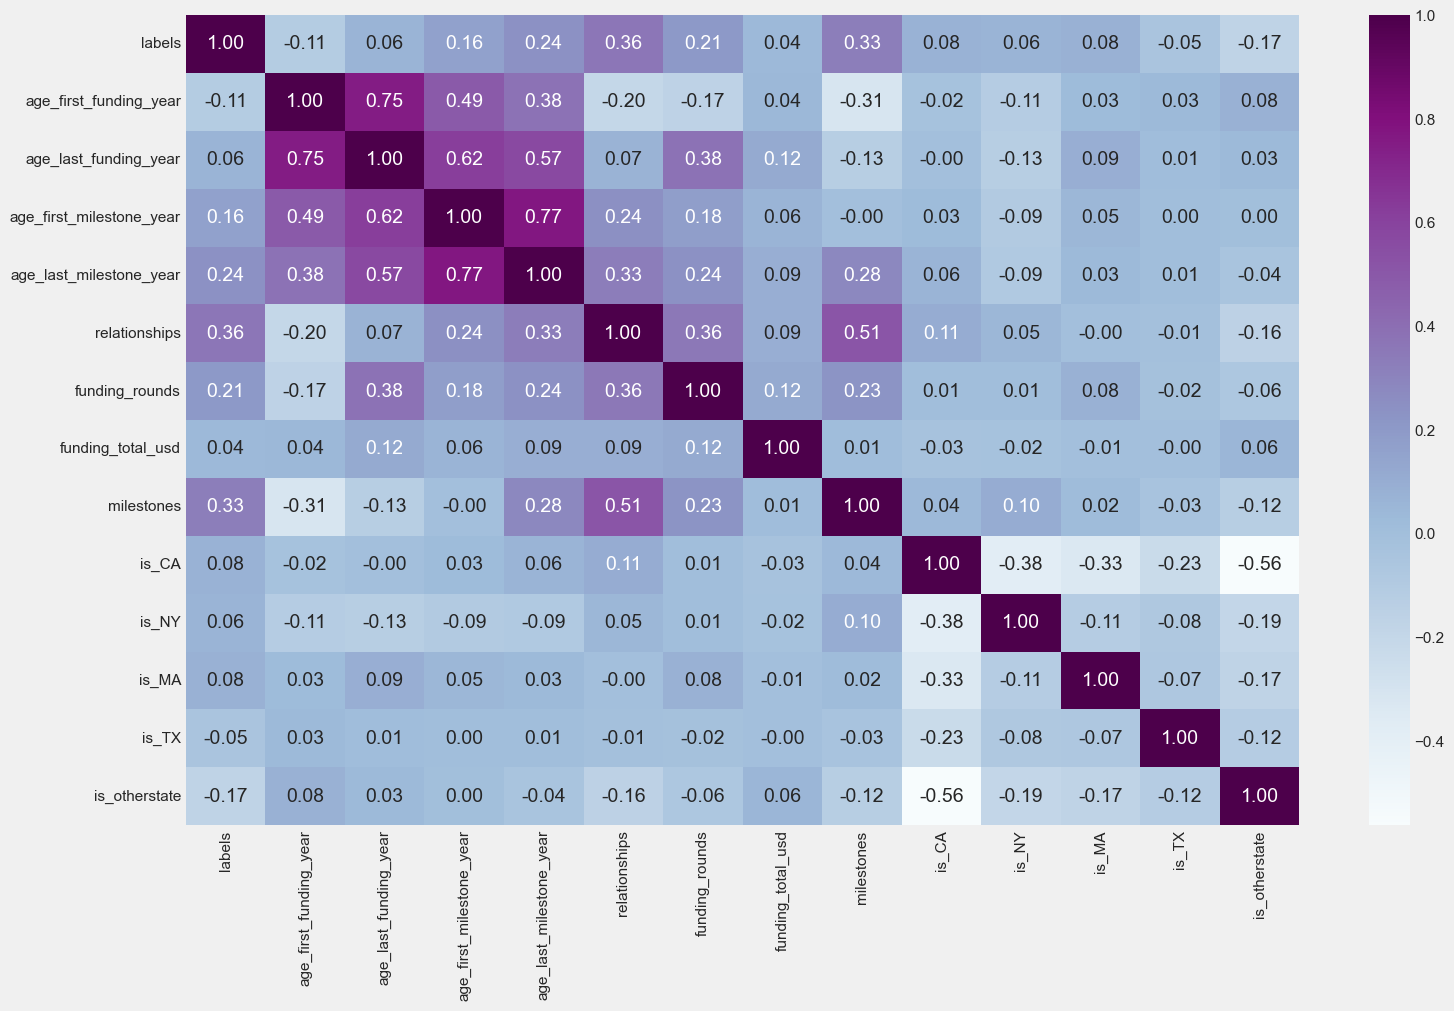

In [27]:
# We divide the correlation matrix to simplify the graph and make it readable
features = ['labels', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
            'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
            'is_MA', 'is_TX', 'is_otherstate']
corr_= data_clean[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
#plt.savefig('fig/correlation matrix.png', tight_box=True);

<AxesSubplot:>

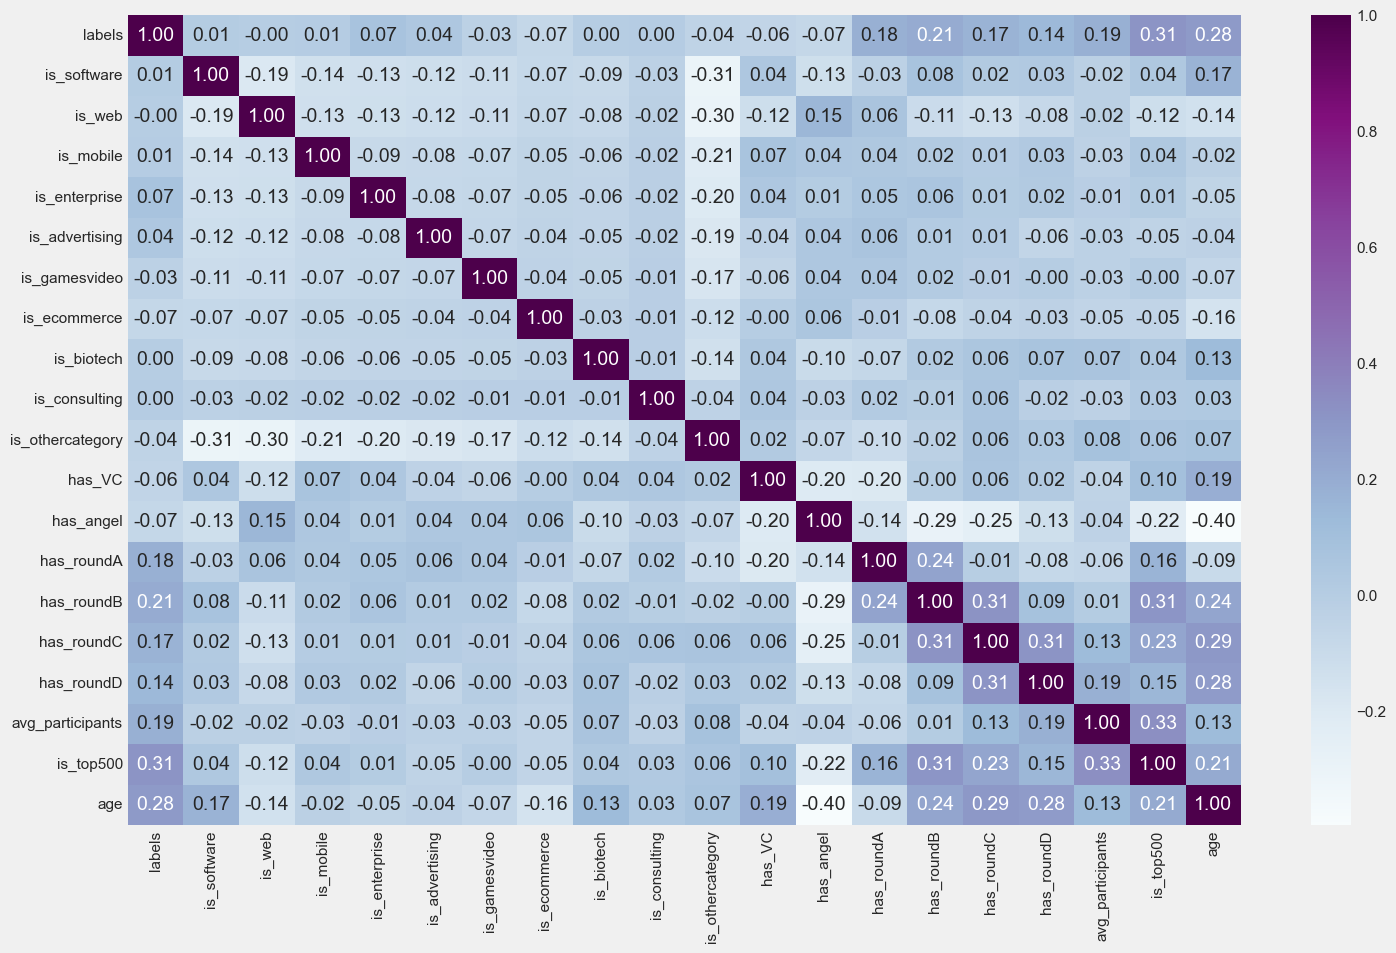

In [28]:
# We divide the correlation matrix to simplify the graph and make it readable
features = ['labels','is_software', 'is_web', 'is_mobile', 
            'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
            'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'age']
corr_= data_clean[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
#plt.savefig('fig/correlation matrix.png', tight_box=True);

As we can see there is some features with positive correlation with target, such as `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`, `relationship`, `funding_rounds`, `milestones`, `funding_total_usd`, `is_CA`, `is_NY`, `is_MA`, `is_software`, `is_mobile`, `is_enterprise`, `is_advertising`, `has_roundA`, `has_roundB`, `has_roundC`, `has_roundD`, `avg_participants`, `is_top500`, and `age`

## Logaritmic Transformation

**Let's use logaritmic transformation to make the values have more normal distribution**

In [29]:
features = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
            'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd',
            'milestones', 'avg_participants', 'age']
df_pre = data_clean.copy()
for var in features:
    df_pre['log_'+var]= (data_clean[var]+1).apply(np.log)

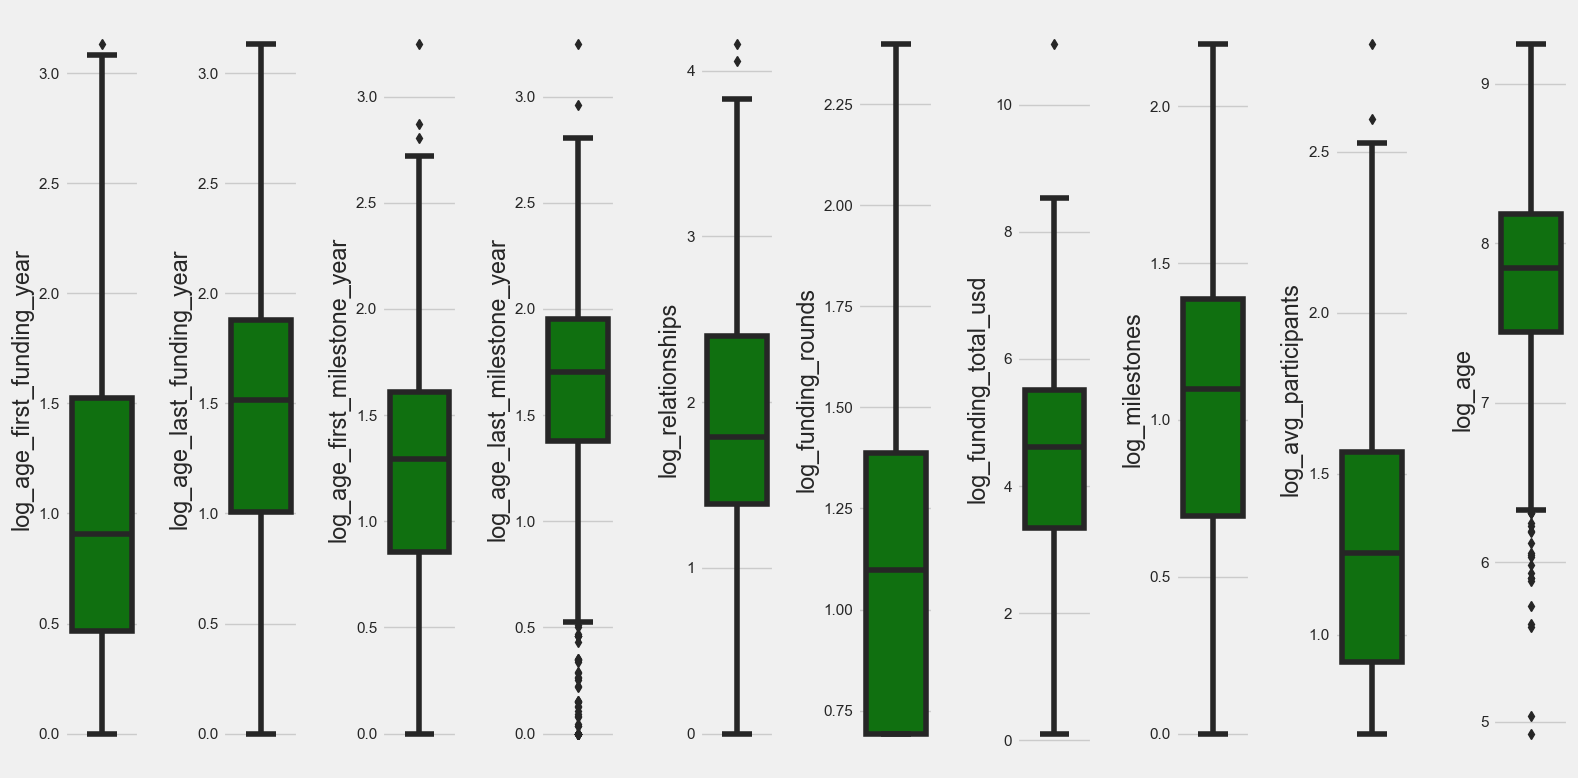

In [30]:
# Now let's take a look once more to this feature that have been transform
featuress = ['log_age_first_funding_year', 'log_age_last_funding_year', 'log_age_first_milestone_year',
            'log_age_last_milestone_year', 'log_relationships', 'log_funding_rounds', 'log_funding_total_usd',
            'log_milestones', 'log_avg_participants', 'log_age']
for i in range(0, len(featuress)):
    plt.subplot(1, 10, i+1)
    sns.boxplot(y=df_pre[featuress[i]],color='green',orient='v')
    plt.tight_layout()
#plt.savefig('fig/Boxplot.png', tight_box=True)

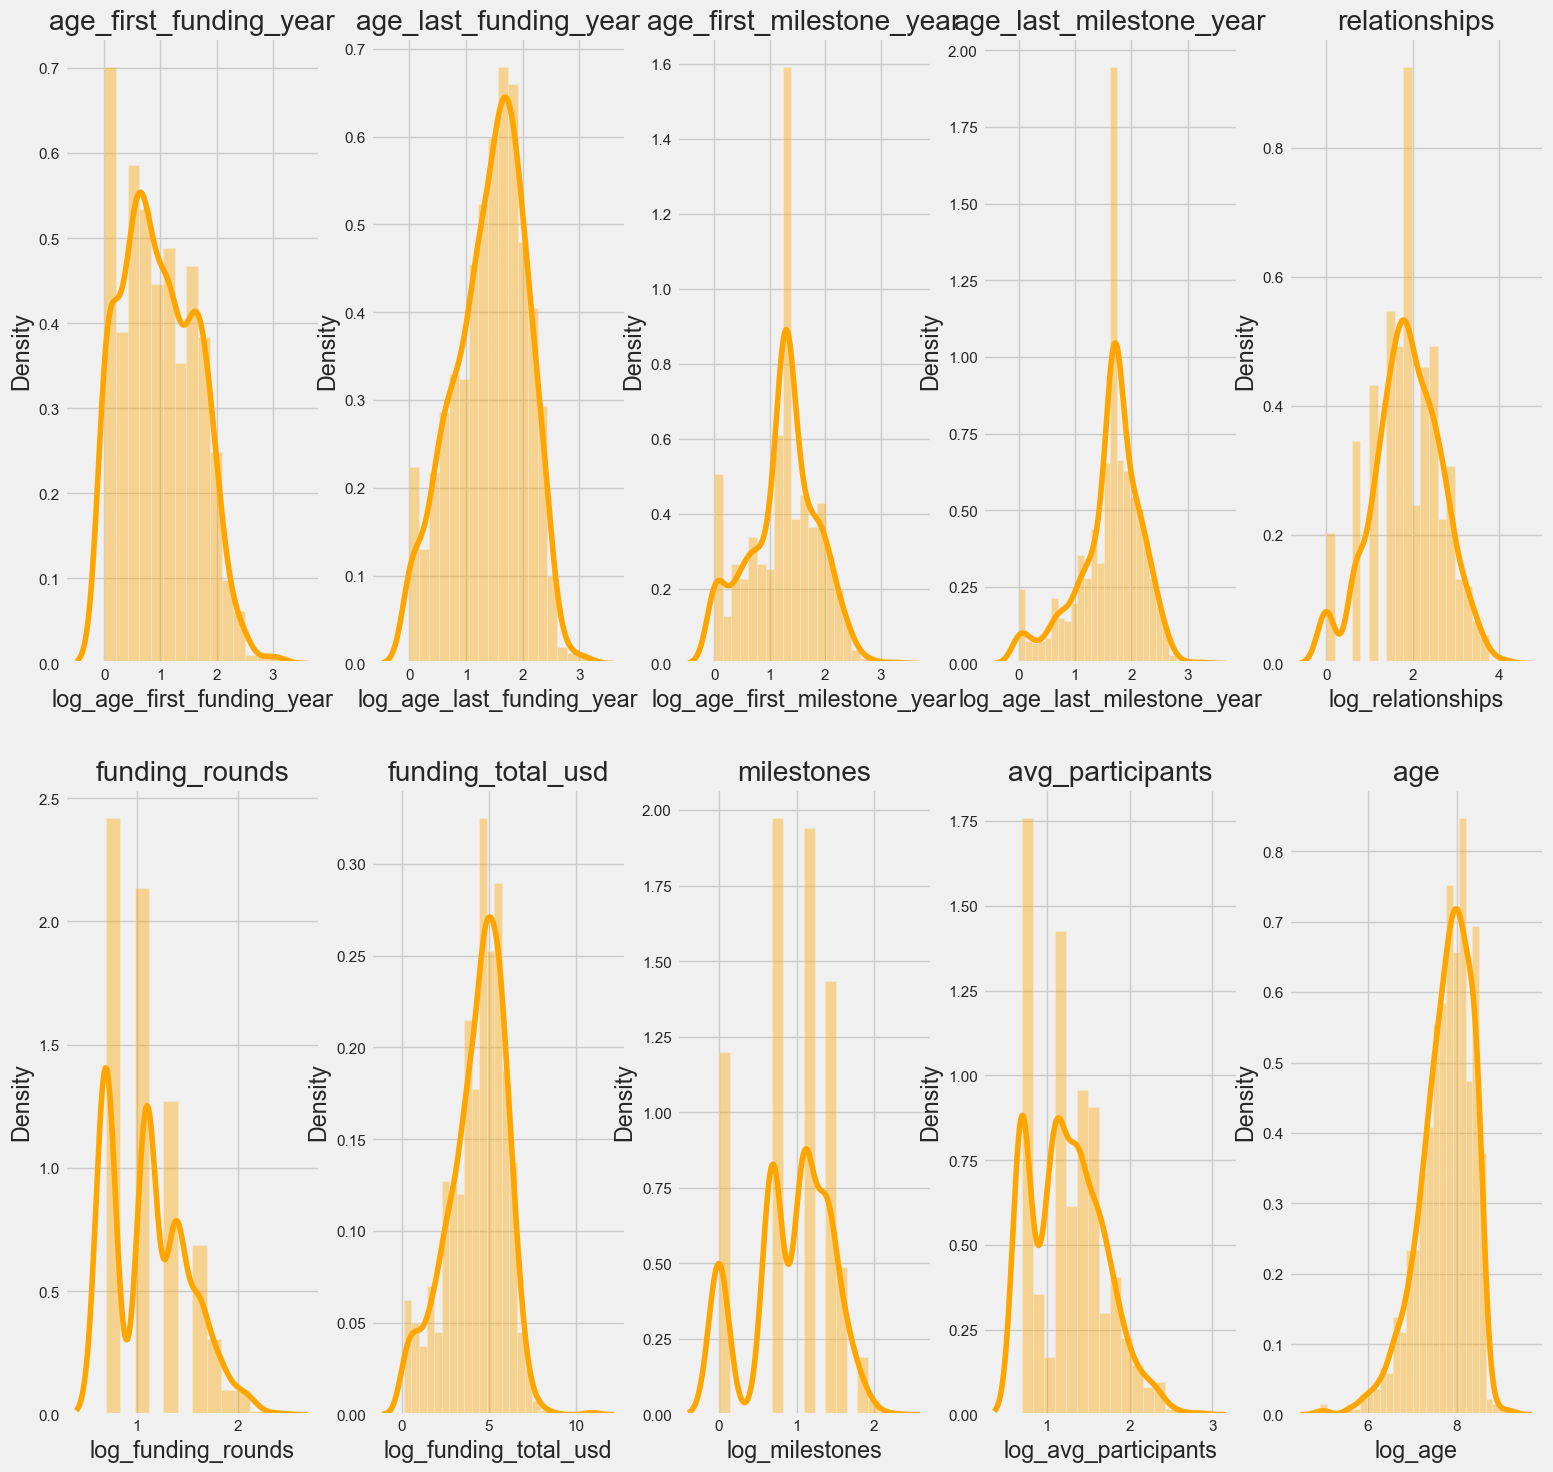

In [31]:
# now let's use distplot to see the distribution of features values
plt.figure(figsize=(17,17),dpi=100)
for i in range(len(featuress)):
    plt.subplot(2,5,i+1)
    plt.title("{}". format(features[i]))
    sns.distplot(df_pre[featuress[i]], color="orange");

**Okay, now it's finally distribute more normal than before, but some features still have some outlier left**

## Normalization

In [36]:
for var in features:
    df_pre['nor_'+var] = MinMaxScaler().fit_transform(df_pre[var].values.reshape(len(df_pre),1))

In [37]:
df_pre.head()

state_code           city               name  labels founded_at  closed_at  \
0         CA      San Diego        Bandsintown       1 2007-01-01 2013-10-31   
1         CA      Los Gatos          TriCipher       1 2000-01-01 2013-10-31   
2         CA      San Diego              Plixi       1 2009-03-18 2013-10-31   
3         CA      Cupertino  Solidcore Systems       1 2002-01-01 2013-10-31   
4         CA  San Francisco     Inhale Digital       0 2010-08-01 2012-10-01   

  first_funding_at last_funding_at  age_first_funding_year  \
0       2009-04-01      2010-01-01                  2.2493   
1       2005-02-14      2009-12-28                  5.1260   
2       2010-03-30      2010-03-30                  1.0329   
3       2005-02-17      2007-04-25                  3.1315   
4       2010-08-01      2012-04-01                  0.0000   

   age_last_funding_year  ...  nor_age_first_funding_year  \
0                 3.0027  ...                    0.102727   
1                 9.9973  ...                    0.234108   
2                 1.0329  ...                    0.047173   
3                 5.3151  ...                    0.143018   
4                 1.6685  ...                    0.000000   

   nor_age_last_funding_year  nor_age_first_milestone_year  \
0                   0.137135                      0.189124   
1                   0.456583                      0.283797   
2                   0.047173                      0.059044   
3                   0.242744                      0.243173   
4                   0.076201                      0.001556   

   nor_age_last_milestone_year  nor_relationships  nor_funding_rounds  \
0                     0.271587           0.047619            0.222222   
1                     0.283797           0.142857            0.333333   
2                     0.089346           0.079365            0.000000   
3                     0.243173           0.079365            0.222222   
4                     0.001556           0.031746            0.111111   

   nor_funding_total_usd  nor_milestones  nor_avg_participants   nor_age  
0               0.000064           0.375              0.000000  0.407600  
1               0.007033           0.125              0.250000  0.600000  
2               0.000454           0.250              0.200000  0.346877  
3               0.007016           0.125              0.155553  0.544996  
4               0.000226           0.125              0.000000  0.279458  

[5 rows x 71 columns]

In [38]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 71 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   state_code                        923 non-null    object        
 1   city                              923 non-null    object        
 2   name                              923 non-null    object        
 3   labels                            923 non-null    int64         
 4   founded_at                        923 non-null    datetime64[ns]
 5   closed_at                         923 non-null    datetime64[ns]
 6   first_funding_at                  923 non-null    datetime64[ns]
 7   last_funding_at                   923 non-null    datetime64[ns]
 8   age_first_funding_year            923 non-null    float64       
 9   age_last_funding_year             923 non-null    float64       
 10  age_first_milestone_year          923 non-null    

# Machine Learning Modeling and Evaluation

## Split Train Test

<AxesSubplot:>

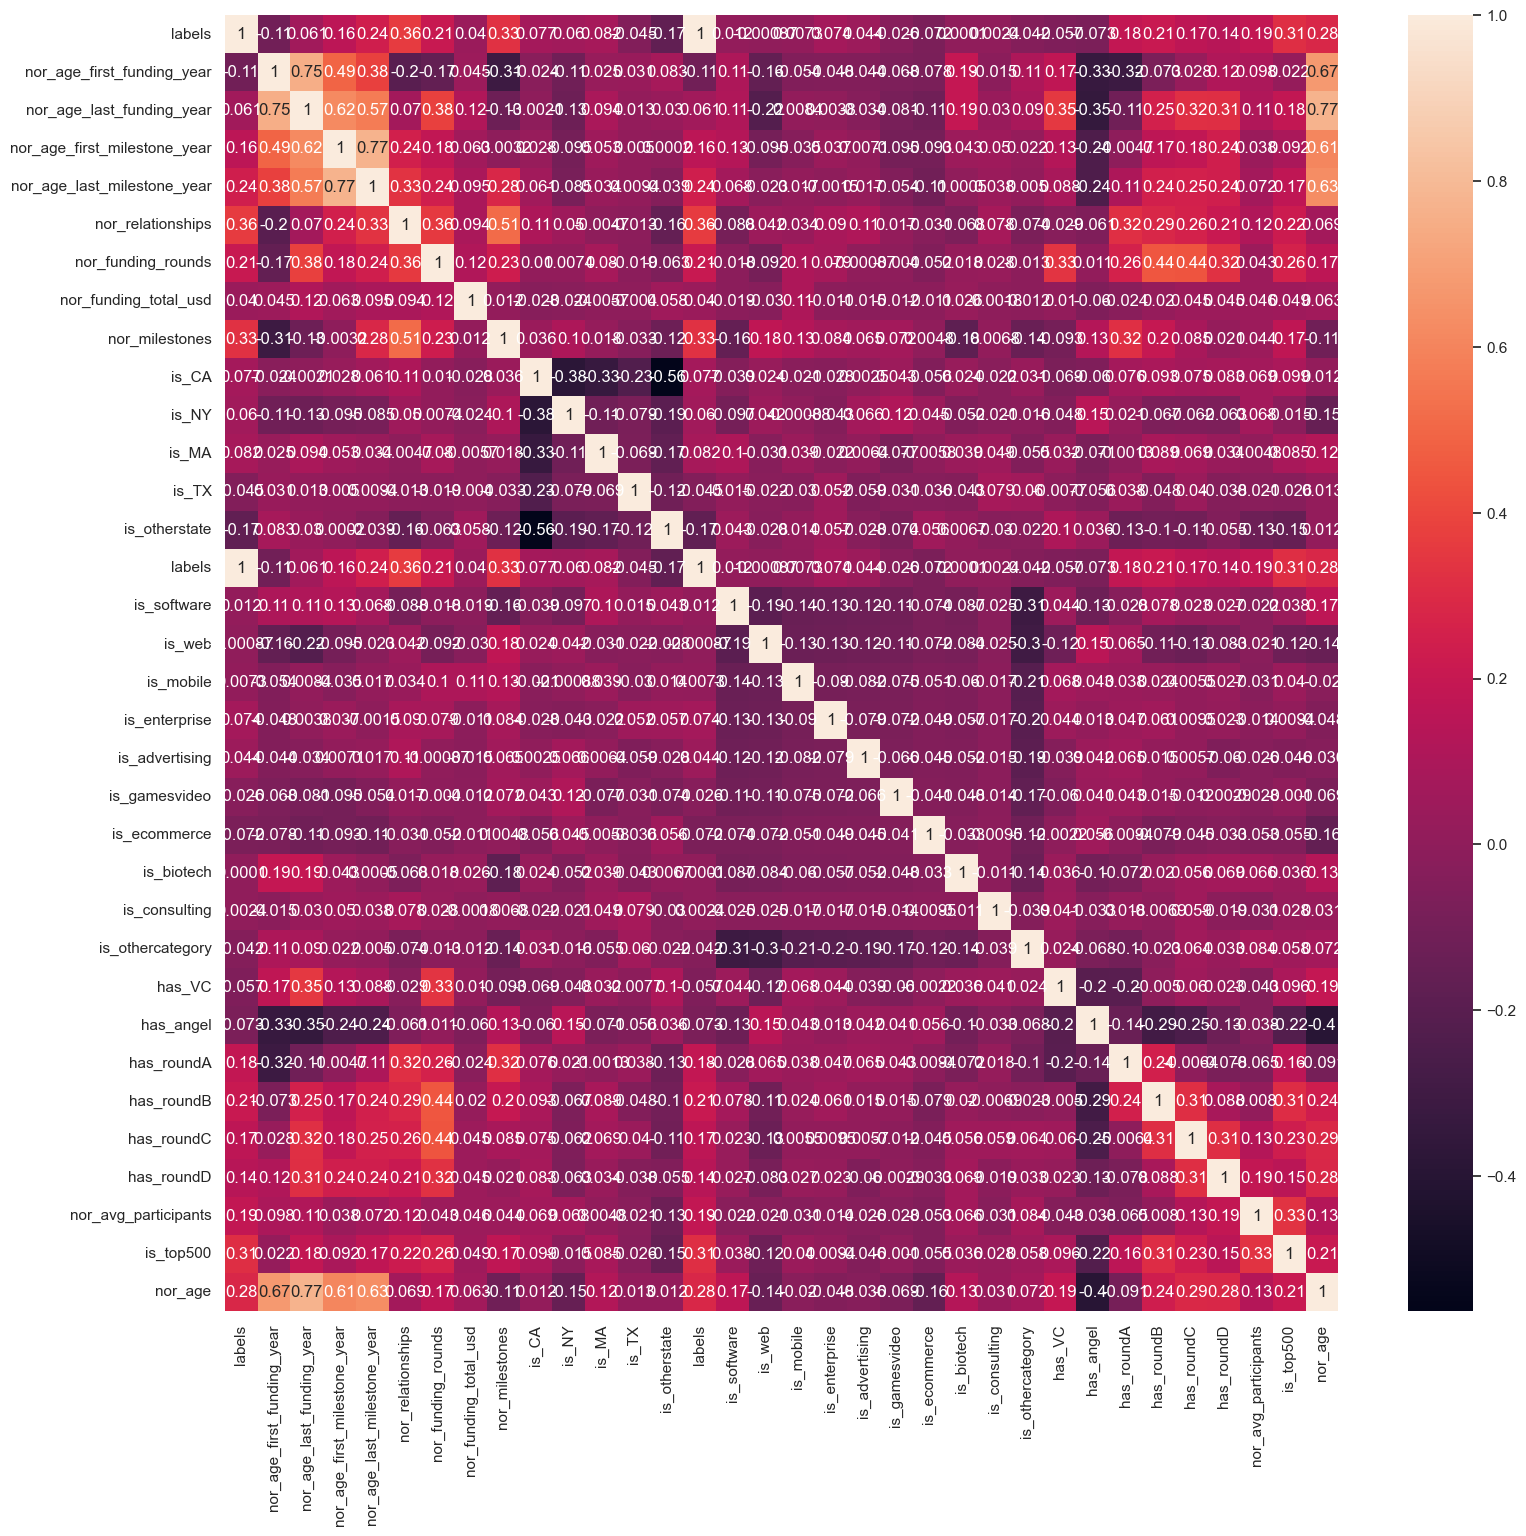

In [39]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_pre[['labels', 'nor_age_first_funding_year', 'nor_age_last_funding_year', 
            'nor_age_first_milestone_year', 'nor_age_last_milestone_year', 'nor_relationships',
            'nor_funding_rounds', 'nor_funding_total_usd', 'nor_milestones', 'is_CA', 'is_NY',
            'is_MA', 'is_TX', 'is_otherstate', 'labels','is_software', 'is_web', 'is_mobile', 
            'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
            'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'nor_avg_participants', 'is_top500', 'nor_age']].corr(), annot=True)
#plt.savefig('fig/split train test.png', tight_box=True)

In [40]:
x = df_pre[['nor_age_first_funding_year', 'nor_age_last_funding_year', 
            'nor_age_first_milestone_year', 'nor_age_last_milestone_year', 'nor_relationships',
            'nor_funding_rounds', 'nor_funding_total_usd', 'nor_milestones', 'is_CA', 'is_NY',
             'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
            'has_roundC', 'has_roundD', 'nor_avg_participants', 'is_top500', 'nor_age']]
y = df_pre['labels']

In [41]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.5, random_state=42) 

In [42]:
x

nor_age_first_funding_year  nor_age_last_funding_year  \
0                      0.102727                   0.137135   
1                      0.234108                   0.456583   
2                      0.047173                   0.047173   
3                      0.143018                   0.242744   
4                      0.000000                   0.076201   
..                          ...                        ...   
918                    0.023648                   0.023648   
919                    0.331208                   0.421421   
920                    0.388013                   0.388013   
921                    0.034659                   0.129380   
922                    0.142515                   0.142515   

     nor_age_first_milestone_year  nor_age_last_milestone_year  \
0                        0.189124                     0.271587   
1                        0.283797                     0.283797   
2                        0.059044                     0.089346   
3                        0.243173                     0.243173   
4                        0.001556                     0.001556   
..                            ...                          ...   
918                      0.023529                     0.183351   
919                      0.243173                     0.243173   
920                      0.364818                     0.364818   
921                      0.030743                     0.155382   
922                      0.162152                     0.162152   

     nor_relationships  nor_funding_rounds  nor_funding_total_usd  \
0             0.047619            0.222222               0.000064   
1             0.142857            0.333333               0.007033   
2             0.079365            0.000000               0.000454   
3             0.079365            0.222222               0.007016   
4             0.031746            0.111111               0.000226   
..                 ...                 ...                    ...   
918           0.142857            0.000000               0.000191   
919           0.015873            0.222222               0.009121   
920           0.079365            0.000000               0.007717   
921           0.190476            0.111111               0.002717   
922           0.063492            0.000000               0.003507   

     nor_milestones  is_CA  is_NY  is_othercategory  has_VC  has_angel  \
0             0.375      1      0                 1       0          1   
1             0.125      1      0                 0       1          0   
2             0.250      1      0                 0       0          0   
3             0.125      1      0                 0       0          0   
4             0.125      1      0                 0       1          1   
..              ...    ...    ...               ...     ...        ...   
918           0.250      1      0                 0       0          0   
919           0.125      0      0                 1       1          0   
920           0.125      1      0                 0       0          0   
921           0.250      1      0                 0       0          0   
922           0.125      1      0                 1       0          0   

     has_roundA  has_roundB  has_roundC  has_roundD  nor_avg_participants  \
0             0           0           0           0              0.000000   
1             0           1           1           1              0.250000   
2             1           0           0           0              0.200000   
3             0           1           1           1              0.155553   
4             0           0           0           0              0.000000   
..          ...         ...         ...         ...                   ...   
918           1           0           0           0              0.333333   
919           0           1           0           0              0.111113   
920           0           0           0           1     

In [43]:
print(df_pre.shape)
print(xtrain.shape)
print(xtest.shape)

(923, 71)
(461, 20)
(462, 20)


## Random Forest Algorithm

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state=42)
rf_model = rf.fit(xtrain, ytrain)

In [45]:
y_predicted = rf.predict(xtest)
y_predicted_train = rf.predict(xtrain)
#eval
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       164
           1       0.82      0.94      0.87       298

    accuracy                           0.82       462
   macro avg       0.83      0.78      0.79       462
weighted avg       0.82      0.82      0.81       462

Random Forest: ROC AUC =  77.6 %
Random Forest: Precision =  81.6 %
Random Forest: Recall =  93.6 %
Random Forest: Accuracy =  82.3 %
Random Forest: F1-Score =  87.2 %


array([[101,  63],
       [ 19, 279]], dtype=int64)

In [42]:
#Save Machine Learning Model
import pickle
pickle.dump(rf_model, open('classifier.pkl', 'wb'))

In [43]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(rf_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(rf_model.score(xtest, ytest)*100,2)),'%')

train score :  100.0 %
test score :  82.25 %


In [44]:
#define function for roc auc curve
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

ROC AUC Score:  77.6 %


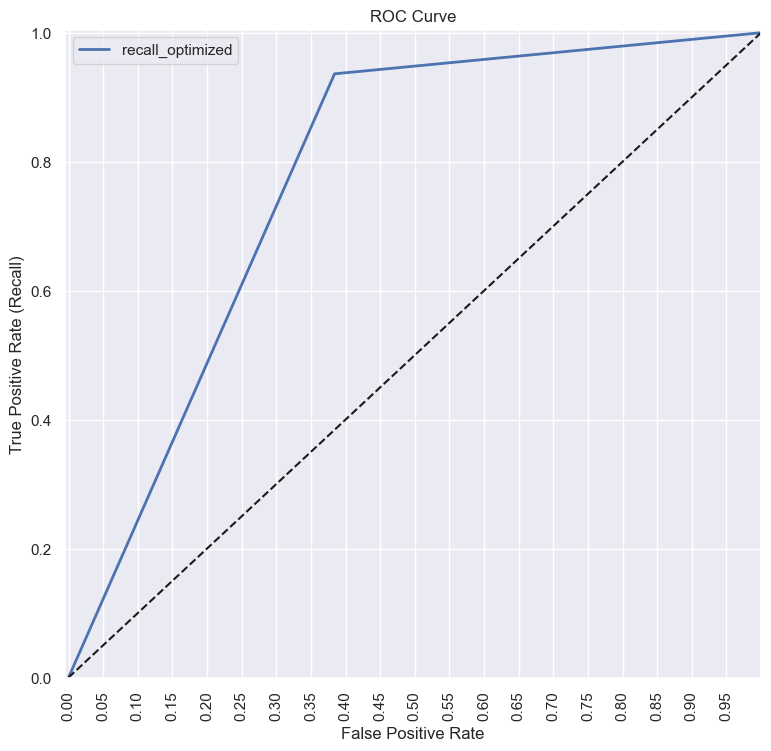

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [46]:
#Define function to see precision and recall threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [47]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

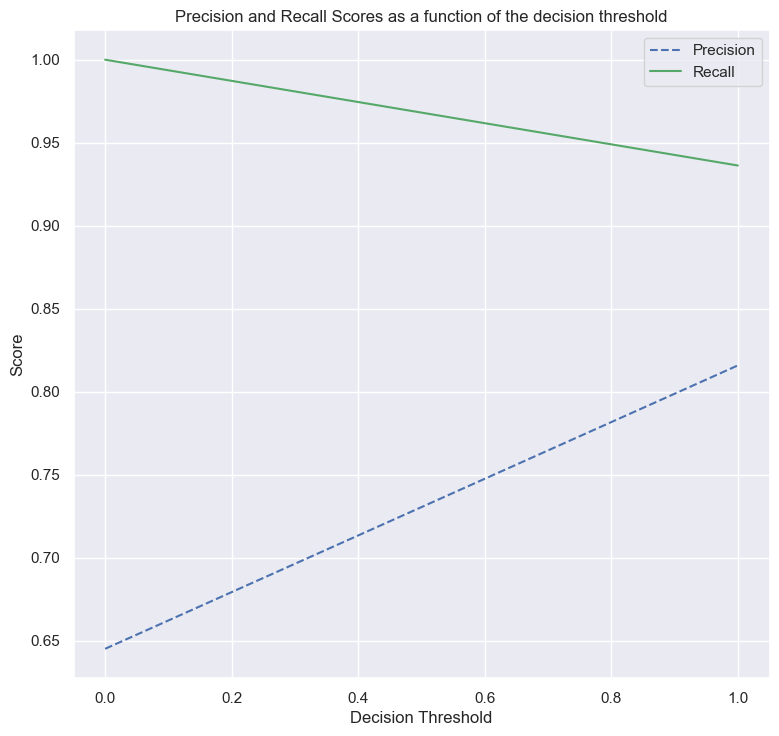

In [48]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

Text(0.5, 1.0, 'feature importance score')

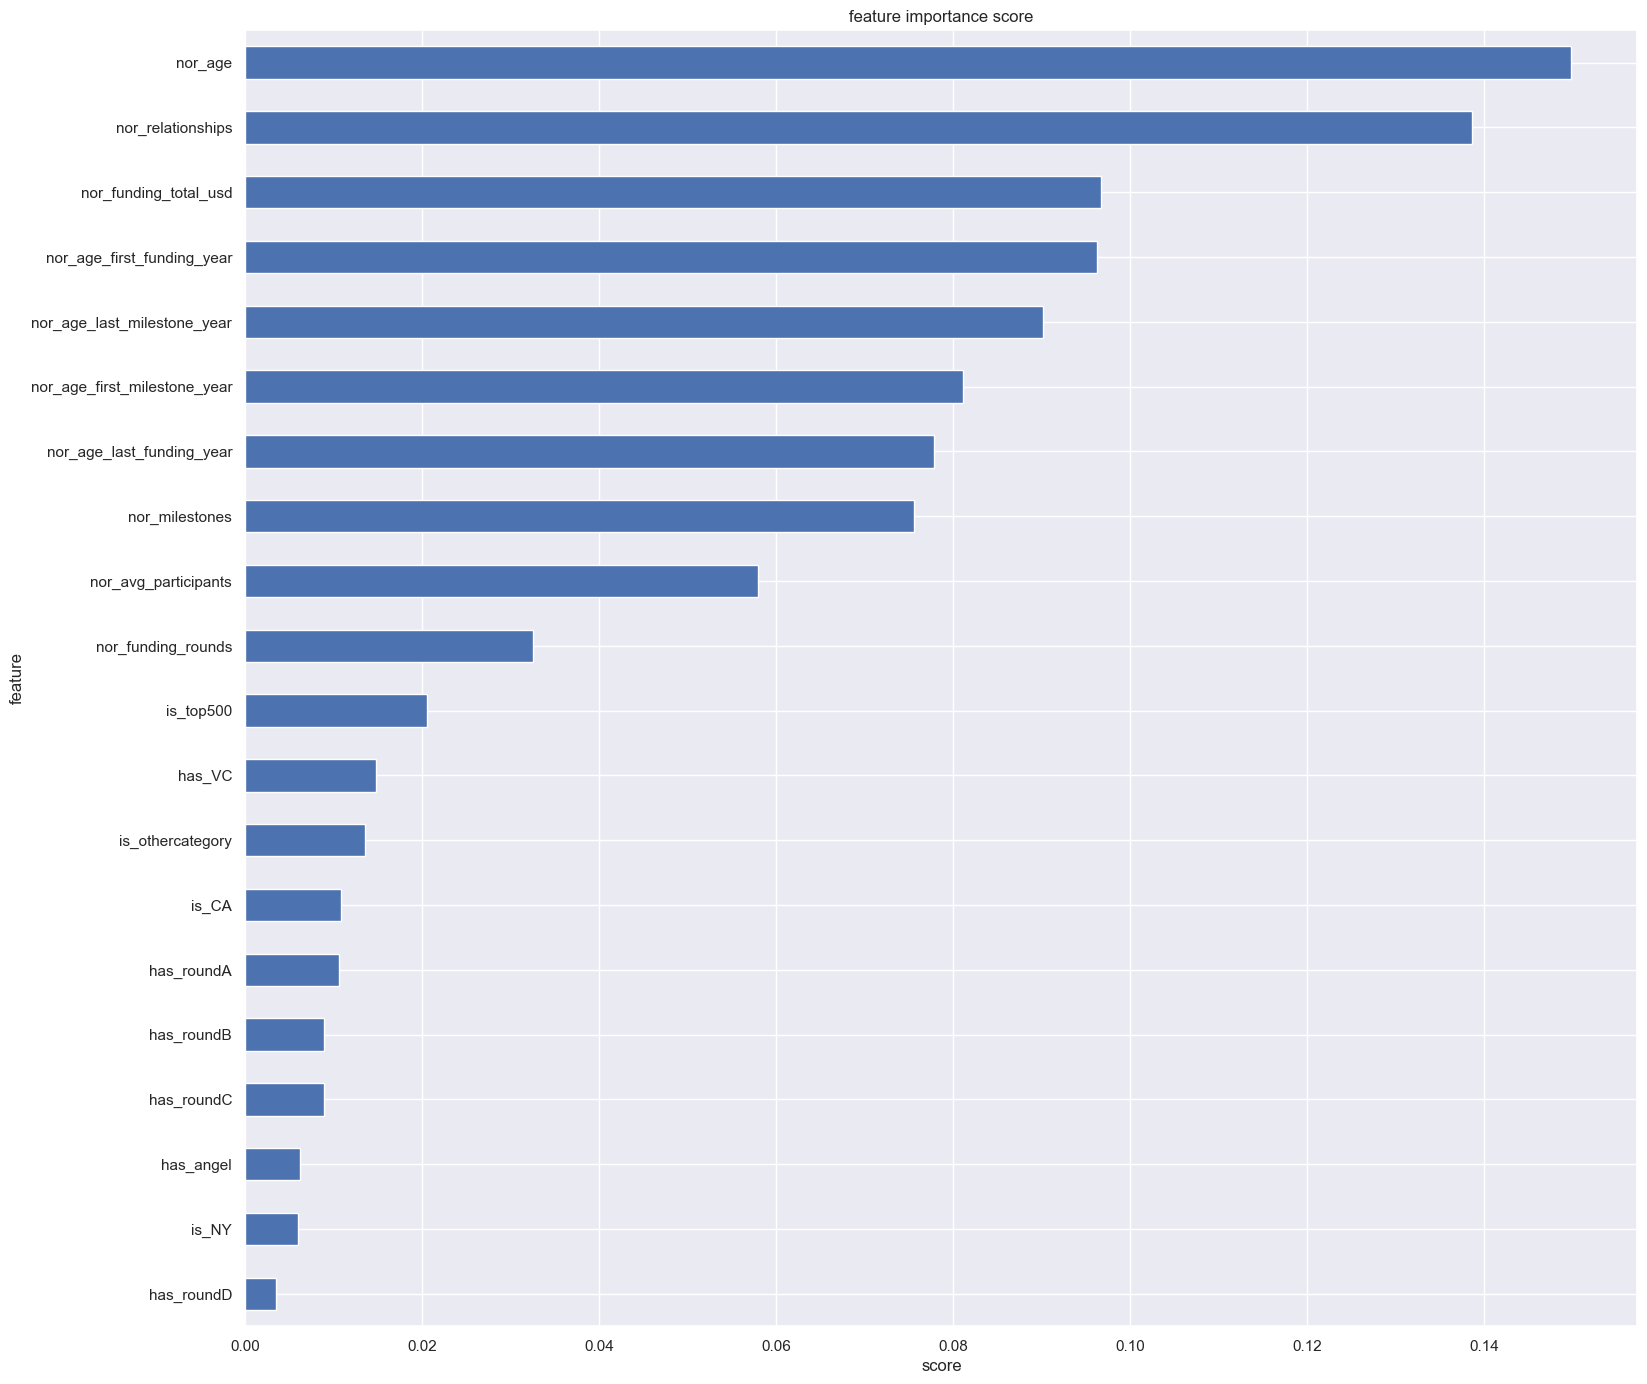

In [49]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

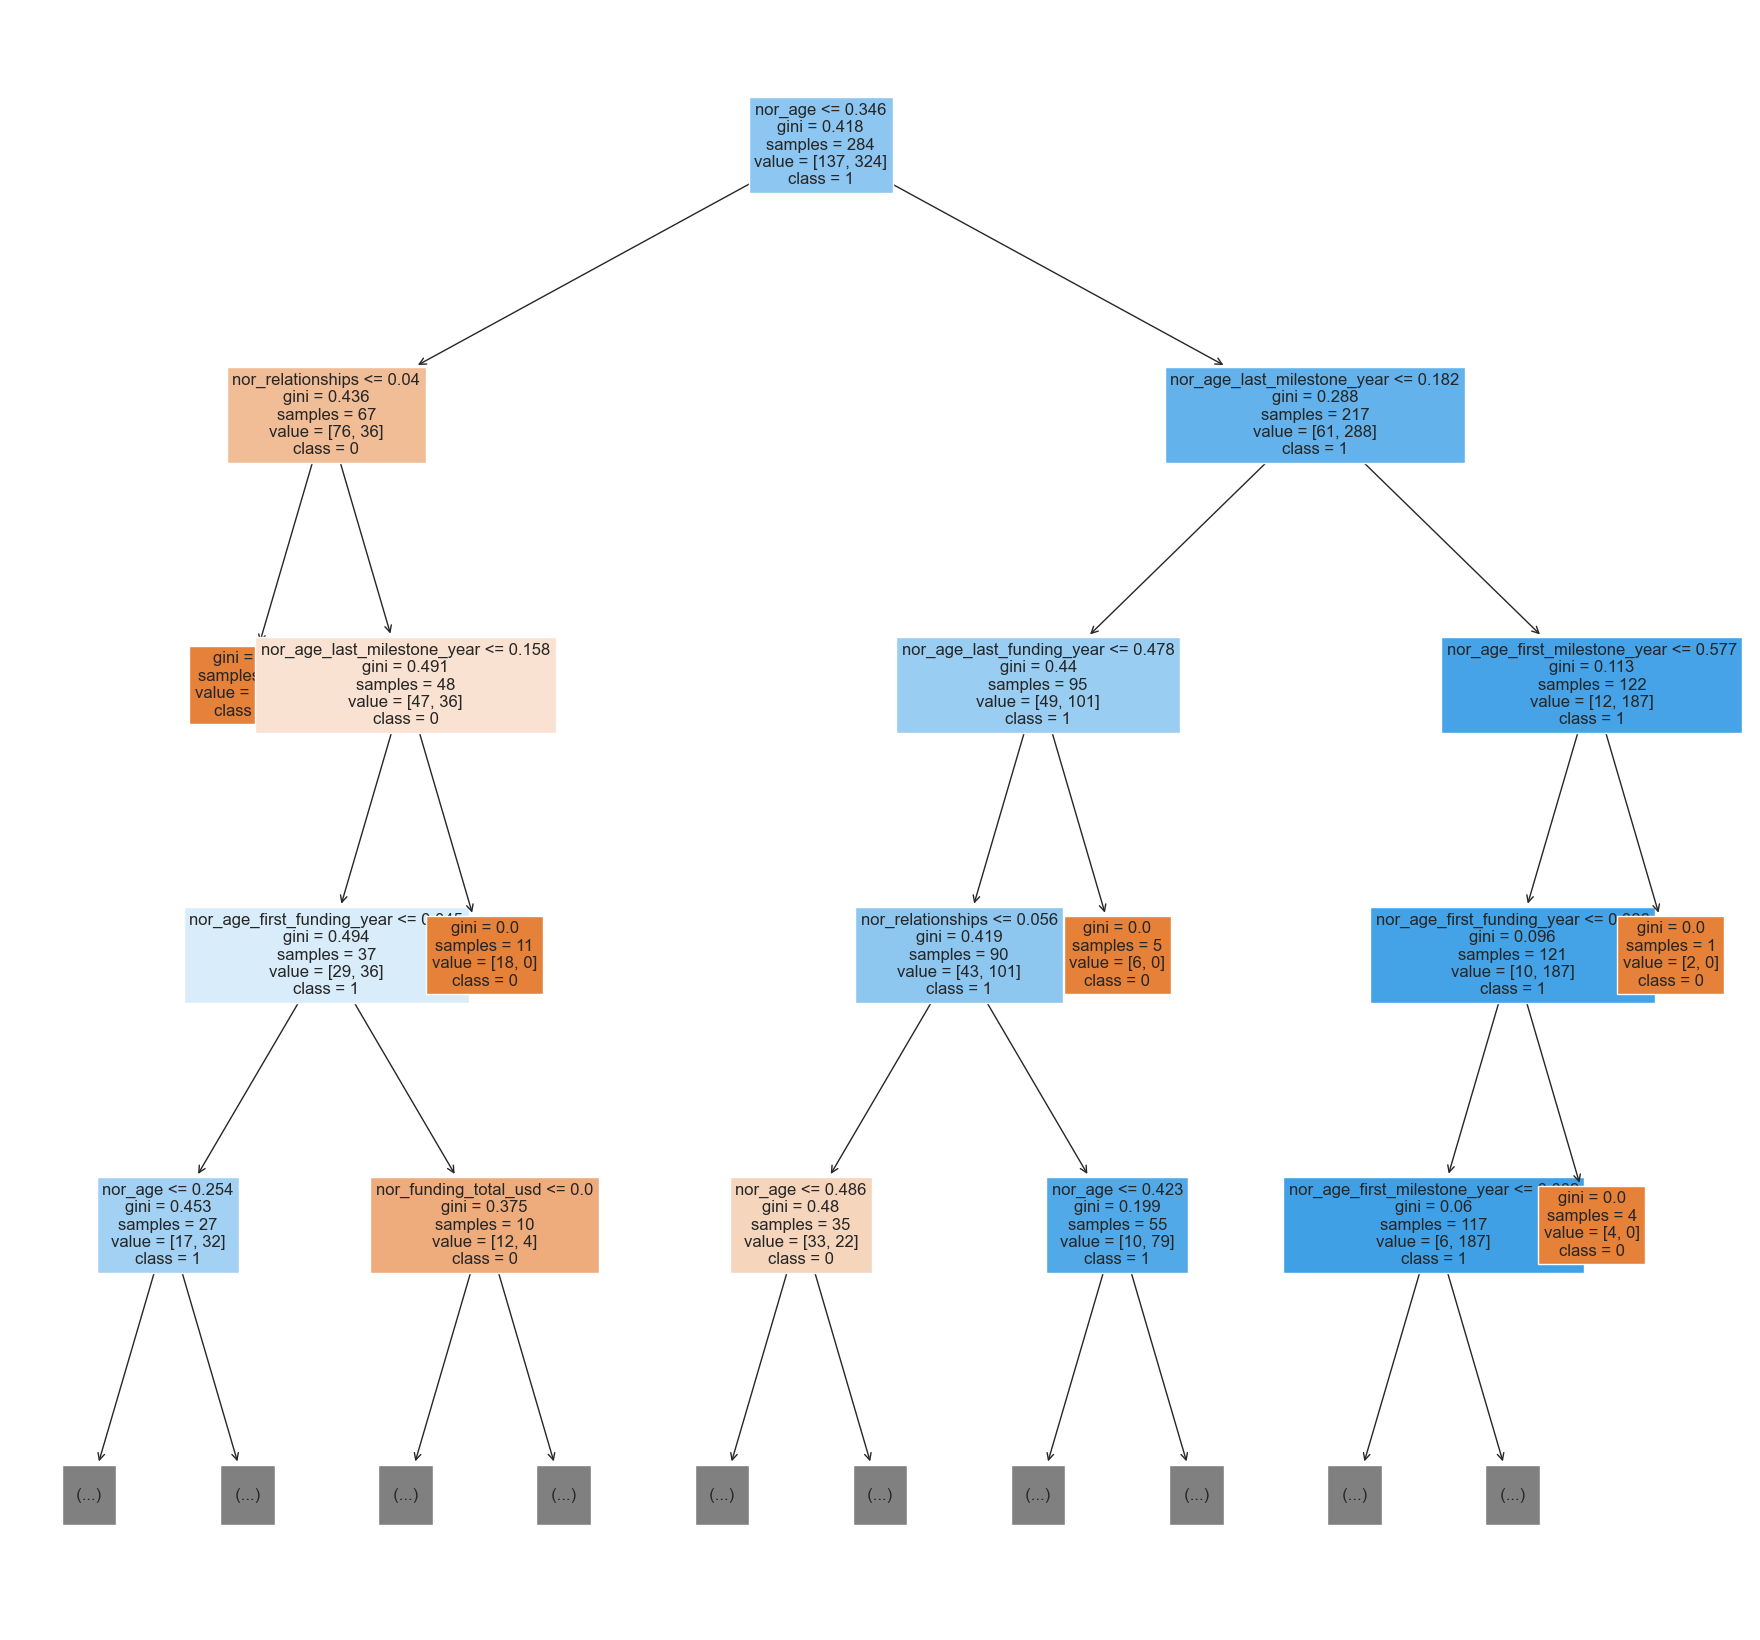

In [50]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(rf.estimators_[2],
               feature_names = x.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=4, fontsize=12)
plt.show()

## Decision Tree Algorithm

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt_model = dt.fit(xtrain,ytrain)
y_predicteddt = dt.predict(xtest)

print('\nclassification report')
print(classification_report(ytest, y_predicteddt)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_predicteddt)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_predicteddt)*100,1)), '%')
confusion_matrix(ytest, y_predicteddt)


classification report
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       164
           1       0.82      0.84      0.83       298

    accuracy                           0.77       462
   macro avg       0.75      0.75      0.75       462
weighted avg       0.77      0.77      0.77       462

Decision Tree: ROC AUC =  74.7 %
Decision Tree: Precision =  81.6 %
Decision Tree: Recall =  83.6 %
Decision Tree: Accuracy =  77.3 %
Decision Tree: F1-Score =  82.6 %


array([[108,  56],
       [ 49, 249]], dtype=int64)

In [52]:
#Save Machine Learning Model
import pickle
pickle.dump(dt_model, open('DecisionTree.pkl', 'wb'))

In [53]:
#Load and print model score
loaded_model = pickle.load(open('DecisionTree.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.7727272727272727


In [54]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  100.0 %
test score :  77.27 %


ROC AUC Score:  74.7 %


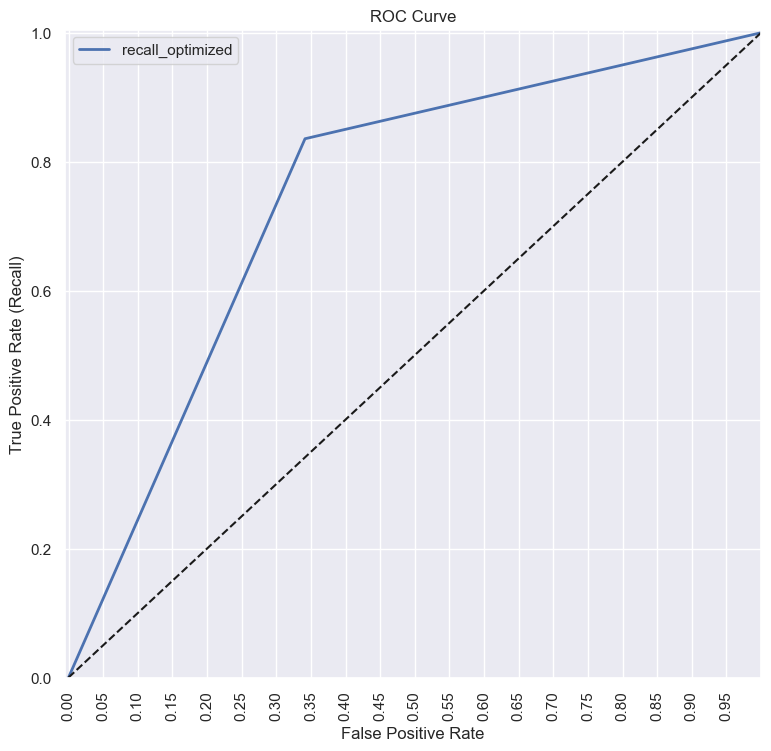

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicteddt)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [56]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicteddt)

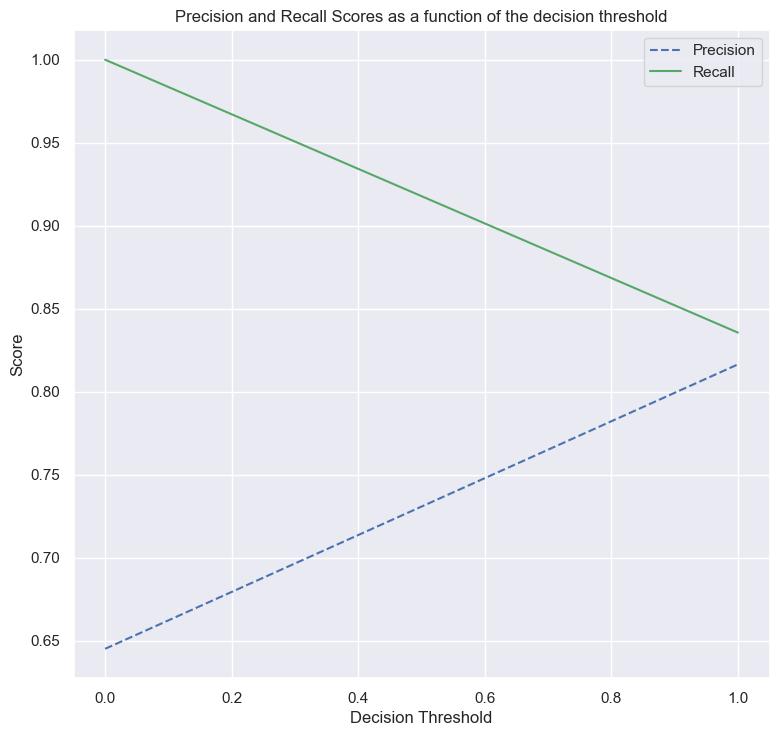

In [57]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

Text(0.5, 1.0, 'feature importance score')

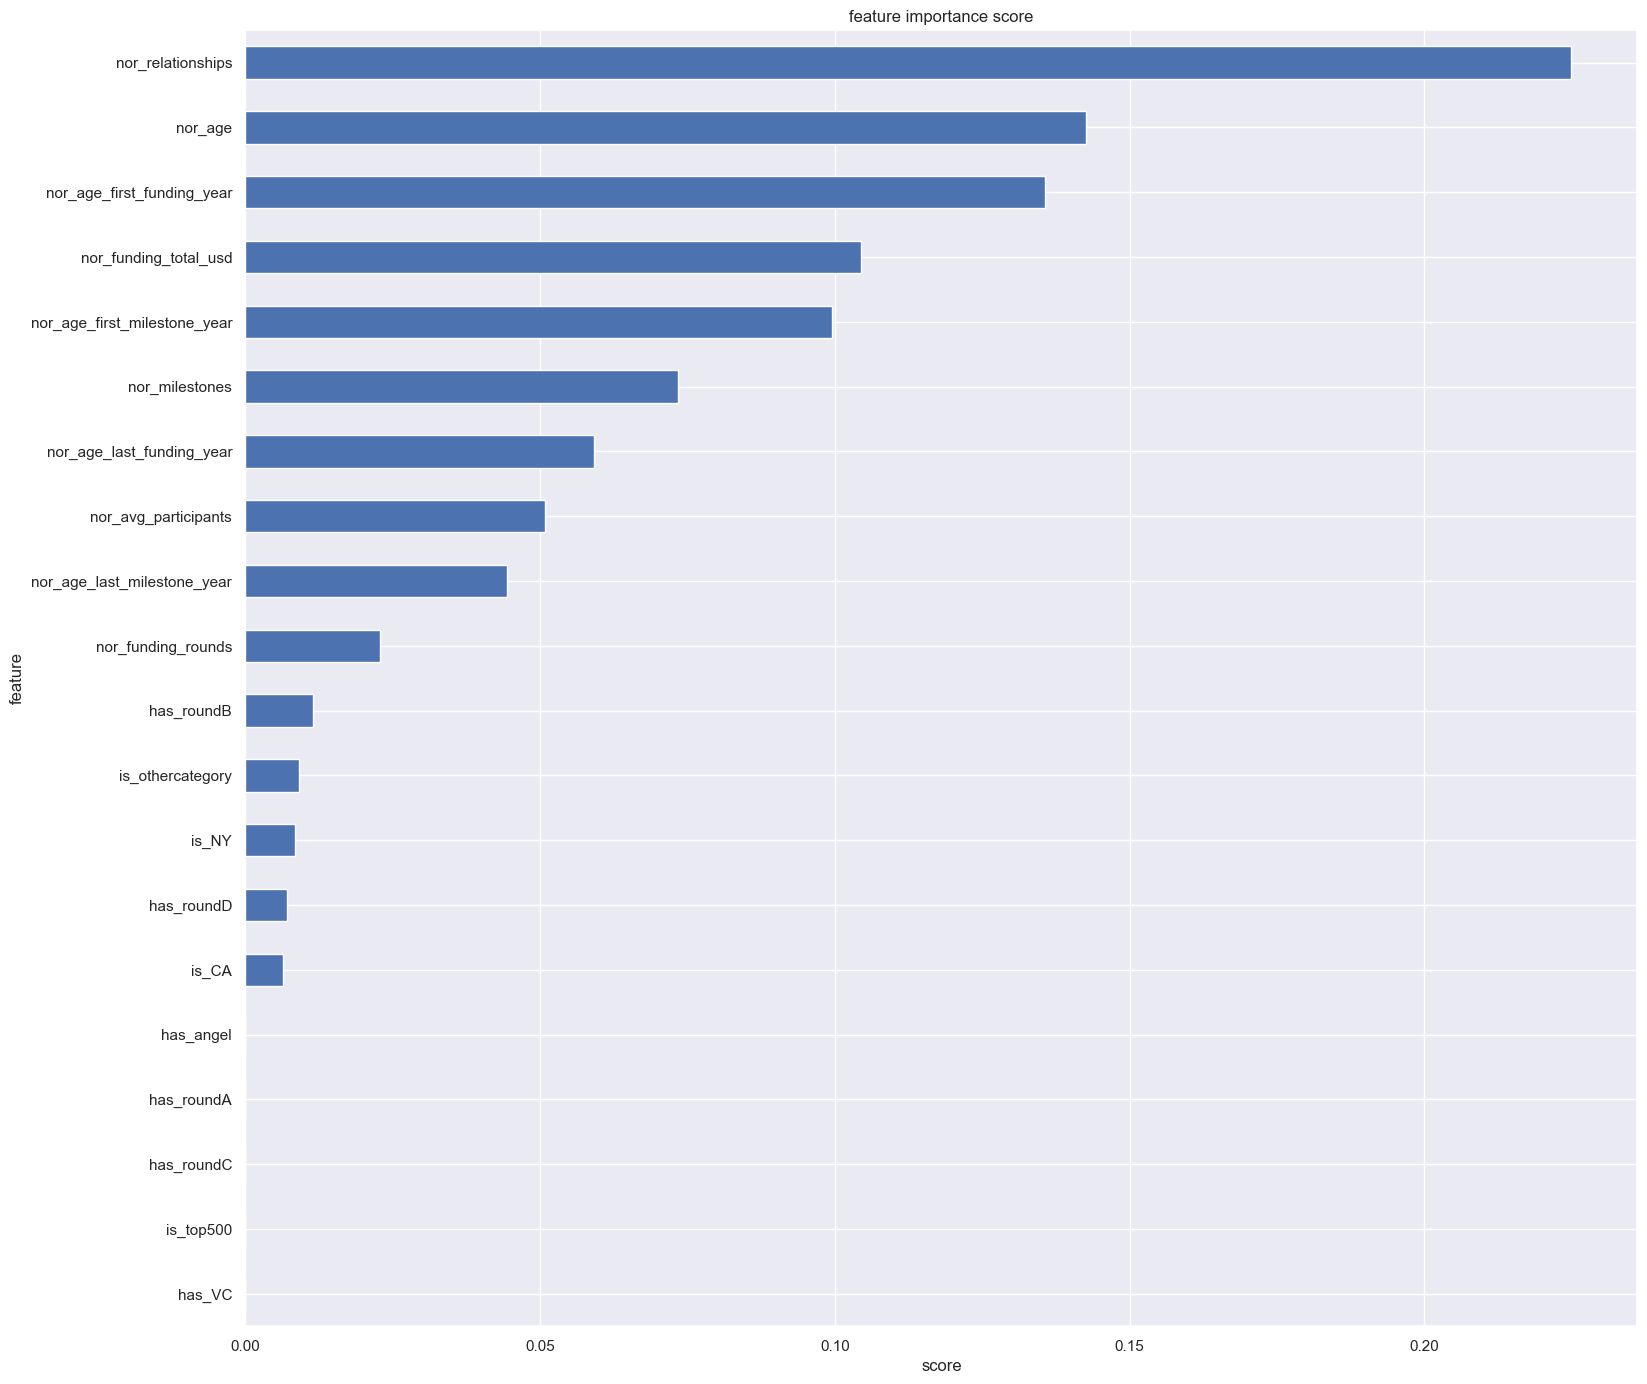

In [58]:
feat_importances = pd.Series(dt.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

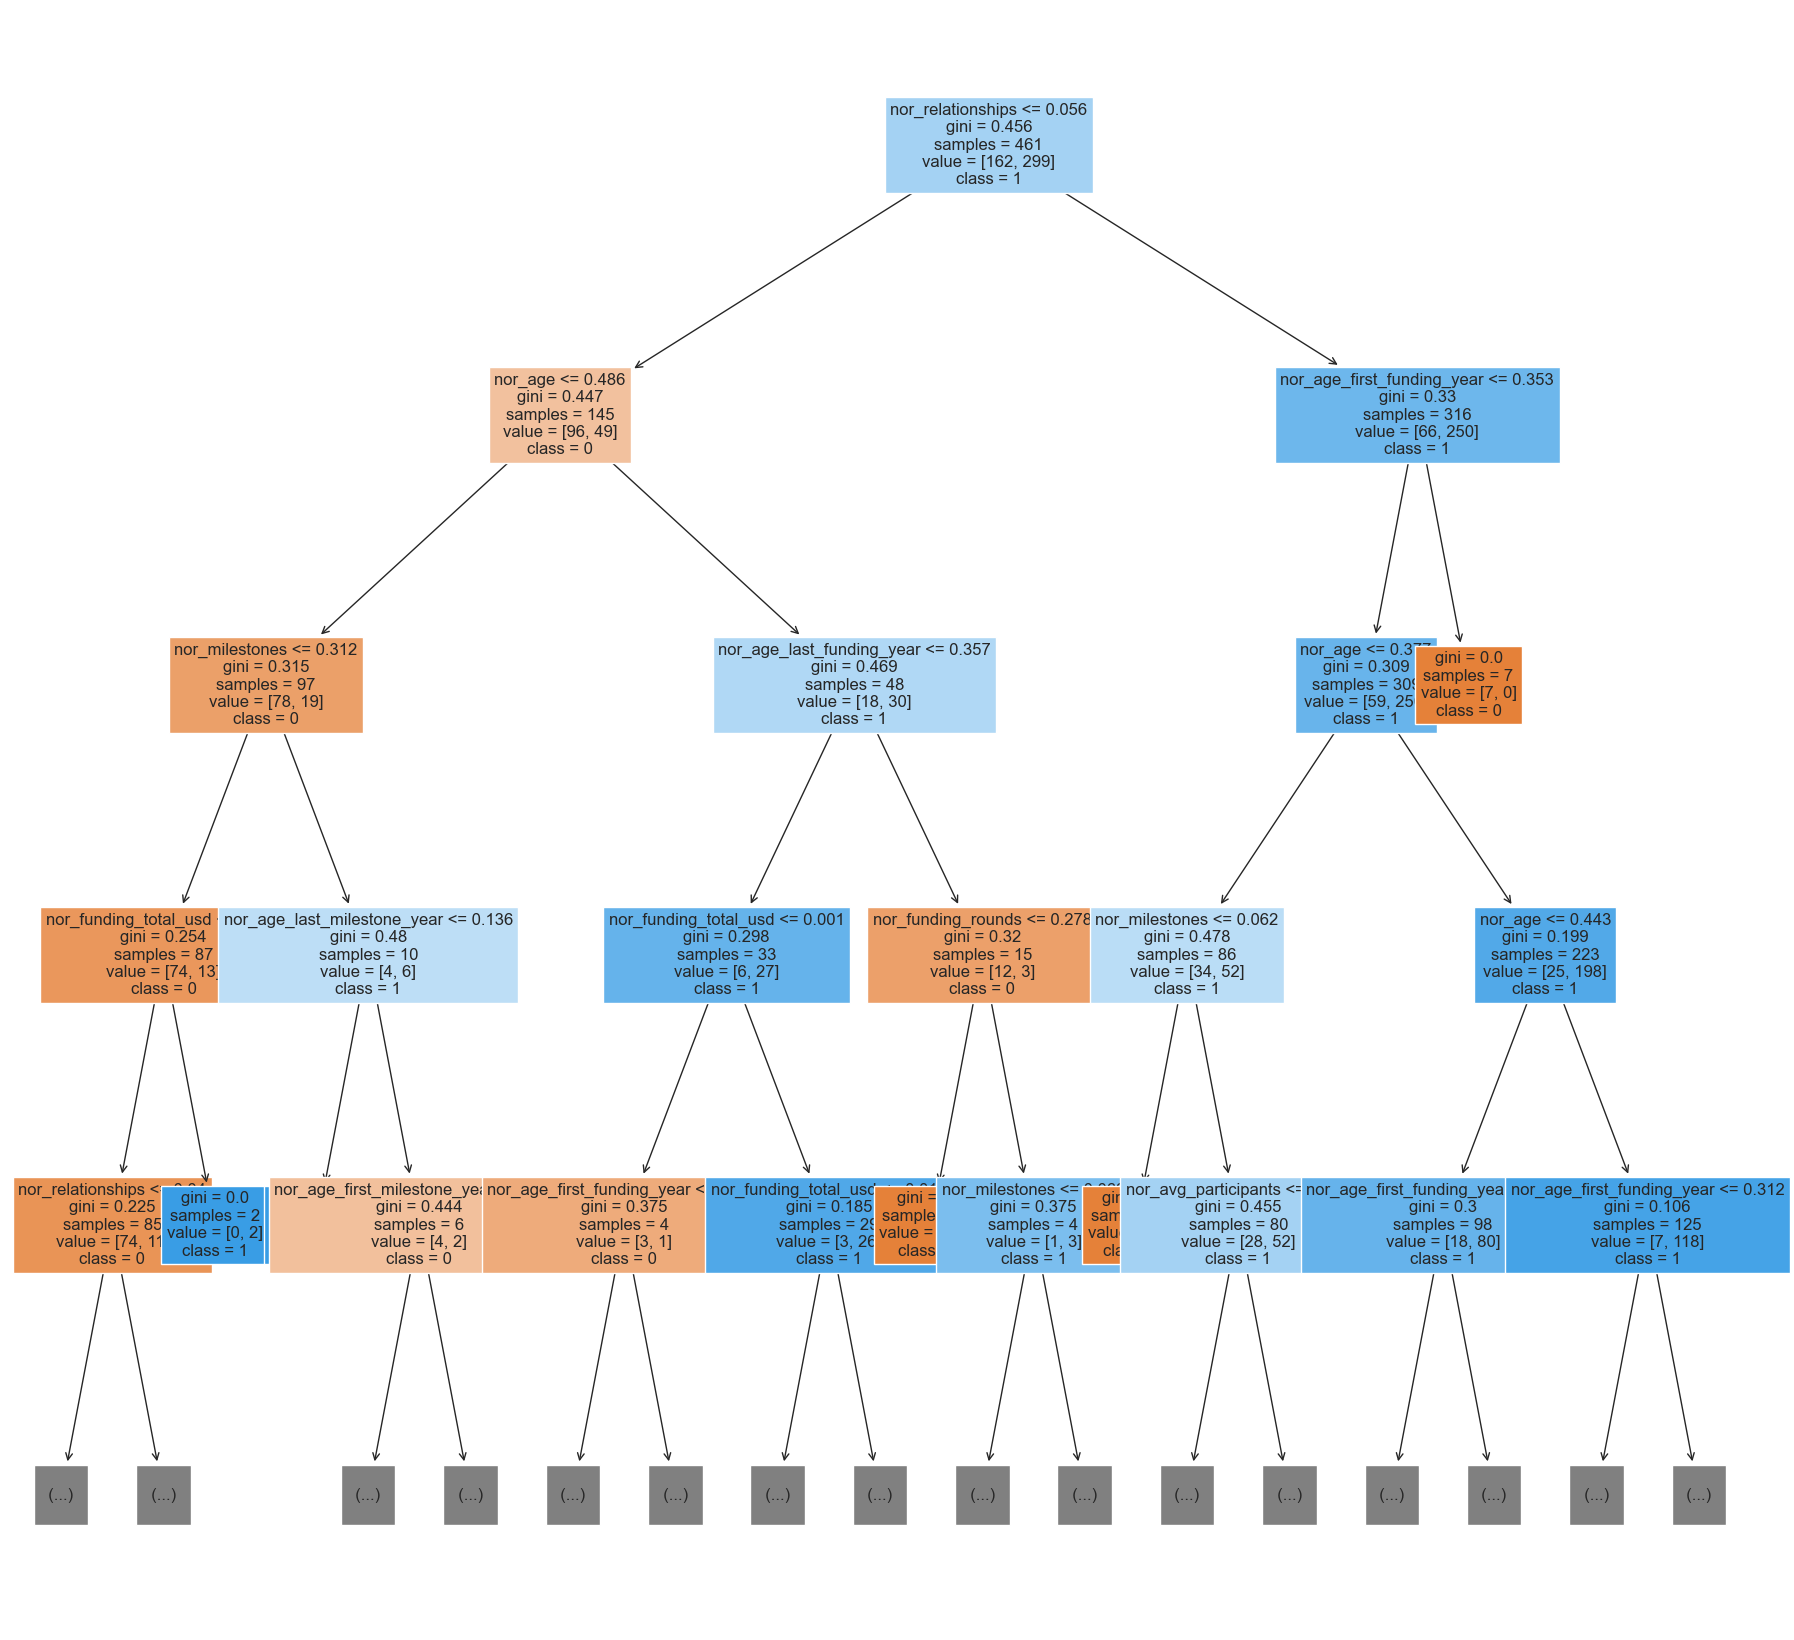

In [59]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(dt,
               feature_names = x.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=4, fontsize=12)
plt.show()

## Logistic Regression Algorithm

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver = 'liblinear')
logreg_model = logreg.fit(xtrain, ytrain)

In [61]:
# Predict the test data
y_predictedlog = logreg.predict(xtest)
y_predictedlog

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,

In [62]:
'''
The output of a Logistic regression model is a probability. 
We can select a threshold value. 
If the probability is greater than this threshold value, 
the event is predicted to happen otherwise it is predicted not to happen.

To get the probability of the label, repectively for class 0 and 1
'''

y_predicted_proba = logreg.predict_proba(xtest)
y_predicted_proba

array([[0.24075164, 0.75924836],
       [0.47685827, 0.52314173],
       [0.31826986, 0.68173014],
       [0.61403574, 0.38596426],
       [0.50291827, 0.49708173],
       [0.80563814, 0.19436186],
       [0.48132513, 0.51867487],
       [0.35298998, 0.64701002],
       [0.25618426, 0.74381574],
       [0.26538369, 0.73461631],
       [0.55826727, 0.44173273],
       [0.59546876, 0.40453124],
       [0.29179746, 0.70820254],
       [0.51507688, 0.48492312],
       [0.30077869, 0.69922131],
       [0.16644249, 0.83355751],
       [0.225124  , 0.774876  ],
       [0.08463002, 0.91536998],
       [0.44234827, 0.55765173],
       [0.62689163, 0.37310837],
       [0.7672873 , 0.2327127 ],
       [0.29099842, 0.70900158],
       [0.39556362, 0.60443638],
       [0.75545313, 0.24454687],
       [0.2908568 , 0.7091432 ],
       [0.16967951, 0.83032049],
       [0.45756562, 0.54243438],
       [0.27274838, 0.72725162],
       [0.40301329, 0.59698671],
       [0.14751866, 0.85248134],
       [0.

In [63]:
print('\nclassification report')
print(classification_report(ytest, y_predictedlog)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predictedlog)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predictedlog)*100,1)), '%')
confusion_matrix(ytest, y_predictedlog)


classification report
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       164
           1       0.78      0.91      0.84       298

    accuracy                           0.77       462
   macro avg       0.77      0.72      0.73       462
weighted avg       0.77      0.77      0.76       462

LogReg: ROC AUC =  72.1 %
LogReg: Precision =  78.0 %
LogReg: Recall =  90.6 %
LogReg: Accuracy =  77.5 %
LogReg: F1-Score =  83.9 %


array([[ 88,  76],
       [ 28, 270]], dtype=int64)

In [64]:
#Save Machine Learning Model
import pickle
pickle.dump(logreg_model, open('Logreg.pkl', 'wb'))

In [65]:
#Load and print model score
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.7748917748917749


In [66]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  77.44 %
test score :  77.49 %


ROC AUC Score:  77.6 %


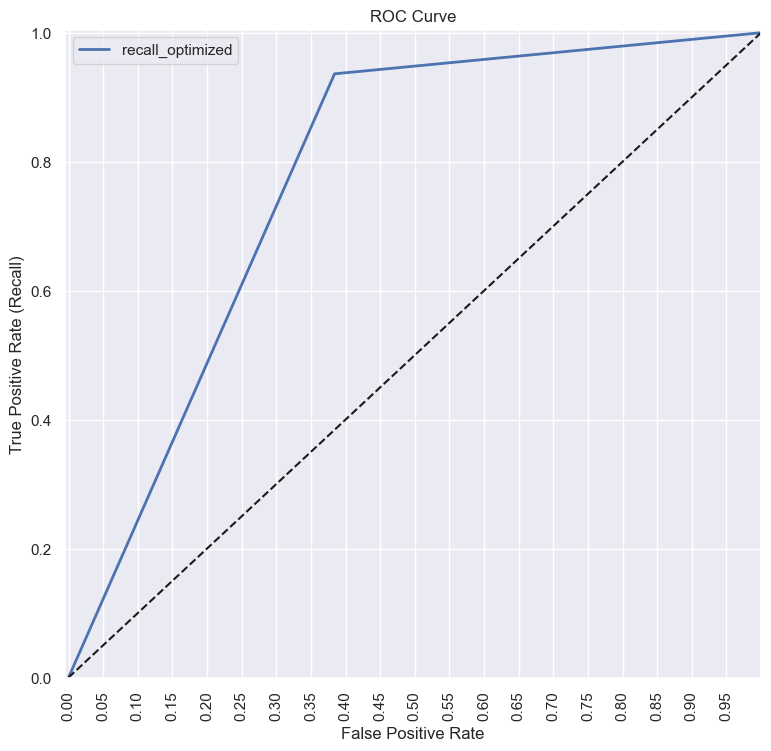

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Logreg ROC Curve.png')

In [68]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

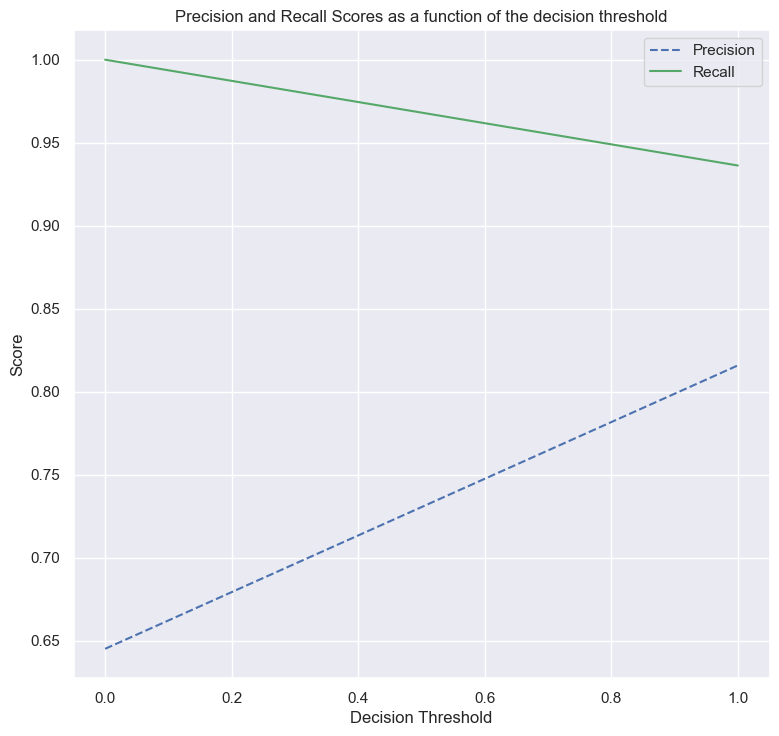

In [69]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold Logreg.png')

## K-Nearest Neighbors Algorithm

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_model = knn.fit(xtrain, ytrain)

# Predict Test
ypredk = knn.predict(xtest)

print('\nclassification report')
print(classification_report(ytest, ypredk)) # generate the precision, recall, f-1 score, num
print('KNN: ROC AUC = ',str(round(roc_auc_score(ytest, ypredk)*100,1)), '%')
print('KNN: Precision = ',str(round(precision_score(ytest, ypredk)*100,1)), '%')
print('KNN: Recall = ',str(round(recall_score(ytest, ypredk)*100,1)), '%')
print('KNN: Accuracy = ',str(round(accuracy_score(ytest, ypredk)*100,1)), '%')
print('KNN: F1-Score = ',str(round(f1_score(ytest, ypredk)*100,1)), '%')
confusion_matrix(ytest, ypredk)


classification report
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       164
           1       0.74      0.82      0.78       298

    accuracy                           0.70       462
   macro avg       0.67      0.65      0.66       462
weighted avg       0.69      0.70      0.69       462

KNN: ROC AUC =  65.0 %
KNN: Precision =  74.2 %
KNN: Recall =  81.9 %
KNN: Accuracy =  69.9 %
KNN: F1-Score =  77.8 %


array([[ 79,  85],
       [ 54, 244]], dtype=int64)

In [75]:
import pickle
filename = 'startup.sav'
pickle.dump(knn, open(filename, 'wb'))
# loading the saved model
loaded_model = pickle.load(open('startup.sav', 'rb'))

In [76]:
#Save Machine Learning Model
import pickle
pickle.dump(knn_model, open('KNN.pkl', 'wb'))

In [77]:
#Load and print model score
loaded_model = pickle.load(open('KNN.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.6991341991341992


In [78]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  76.14 %
test score :  69.91 %


ROC AUC Score:  65.0 %


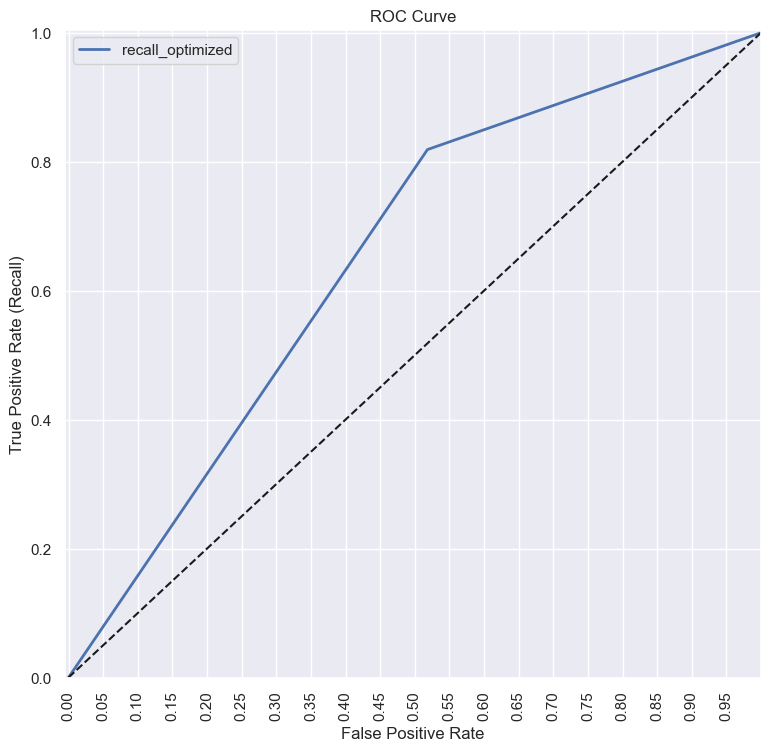

In [79]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypredk)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [80]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypredk)

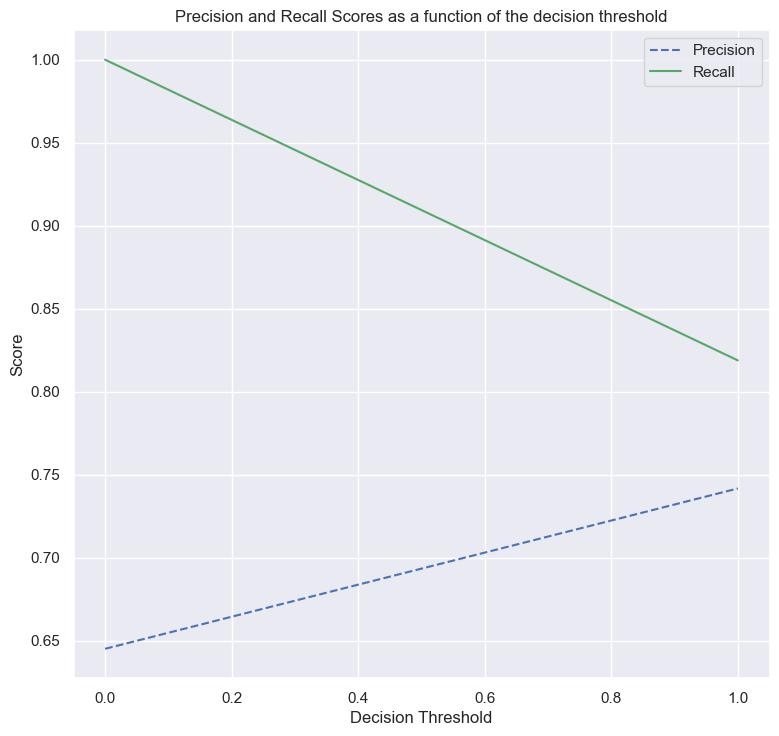

In [81]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

### KNN Hyperparameter Tuning

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#List Hyperparameters yang akan diuji
n_neighbors = list(range(1,30))
p=[1,2]
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']

#Menjadikan ke dalam bentuk dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init Logres dengan Gridsearch, cross validation = 5
knn2 = KNeighborsClassifier()
clf3 = RandomizedSearchCV(knn2, hyperparameters, cv=5, random_state=42)

#Fitting Model
knn_model2 = clf.fit(xtrain, ytrain)

#Prediksi menggunakan model baru
ypredknn = knn_model2.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, ypredknn)) # generate the precision, recall, f-1 score, num
print('KNN: ROC AUC = ',str(round(roc_auc_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Precision = ',str(round(precision_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Recall = ',str(round(recall_score(ytest, ypredknn)*100,1)), '%')
print('KNN: Accuracy = ',str(round(accuracy_score(ytest, ypredknn)*100,1)), '%')
print('KNN: F1-Score = ',str(round(f1_score(ytest, ypredknn)*100,1)), '%')
confusion_matrix(ytest, ypredknn)

NameError: name 'clf' is not defined

In [ ]:
#Save Machine Learning Model
import pickle
pickle.dump(knn_model2, open('KNN_model.pkl', 'wb'))

In [ ]:
#Load and print model score
loaded_model = pickle.load(open('KNN_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

In [83]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  76.14 %
test score :  69.91 %


In [84]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypredknn)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

NameError: name 'ypredknn' is not defined

In [85]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypredknn)

NameError: name 'ypredknn' is not defined

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

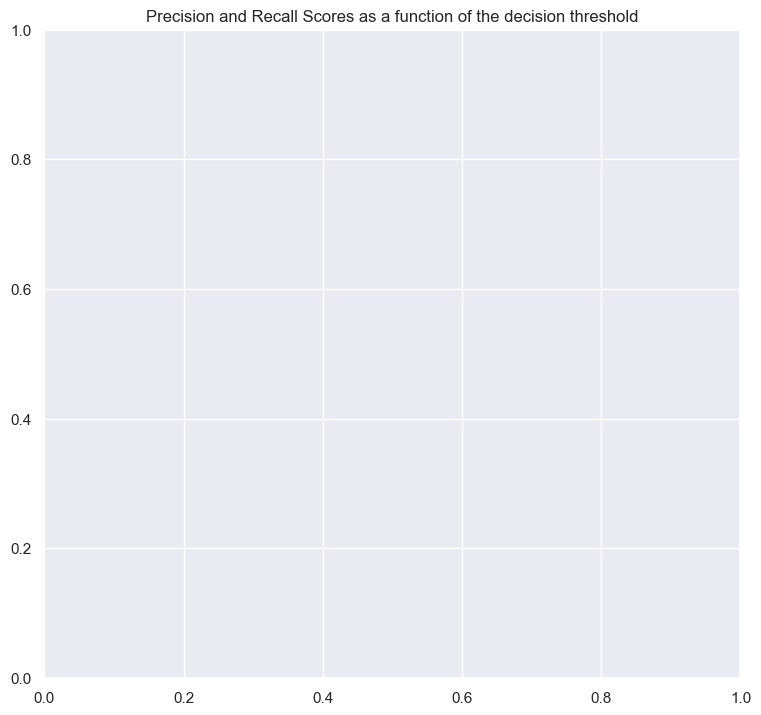

In [86]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

## XGBoost

In [87]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

xgb_classifier = xgb.XGBClassifier()
norm_model = xgb_classifier.fit(xtrain, ytrain)
ypred_x = norm_model.predict(xtest)

print("\nClassification Report")
print(classification_report(ytest, ypred_x))
print('XGBoost: ROC AUC = ', str(round(roc_auc_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Precision = ', str(round(precision_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Recall = ', str(round(recall_score(ytest, ypred_x)*100,1)),"%")
print('XGBoost: Accuracy = ', str(round(accuracy_score(ytest, ypred_x)*100,1)),"%")
print("XGBoost: F1 Score =  ", str(round(f1_score(ytest, ypred_x)*100,1)),"%")
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred_x)



Classification Report
              precision    recall  f1-score   support

           0       0.83      0.66      0.74       164
           1       0.83      0.92      0.88       298

    accuracy                           0.83       462
   macro avg       0.83      0.79      0.81       462
weighted avg       0.83      0.83      0.83       462

XGBoost: ROC AUC =  79.4 %
XGBoost: Precision =  83.3 %
XGBoost: Recall =  92.3 %
XGBoost: Accuracy =  83.1 %
XGBoost: F1 Score =   87.6 %


array([[109,  55],
       [ 23, 275]], dtype=int64)

In [88]:
print("\nTrain vs Test Accuration")
import pickle
pickle.dump(xgb_classifier, open('XGBoost.pkl', 'wb'))

loaded_model = pickle.load(open('XGBoost.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)

print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')


Train vs Test Accuration
train score :  100.0 %
test score :  83.12 %


ROC AUC Score:  79.4 %


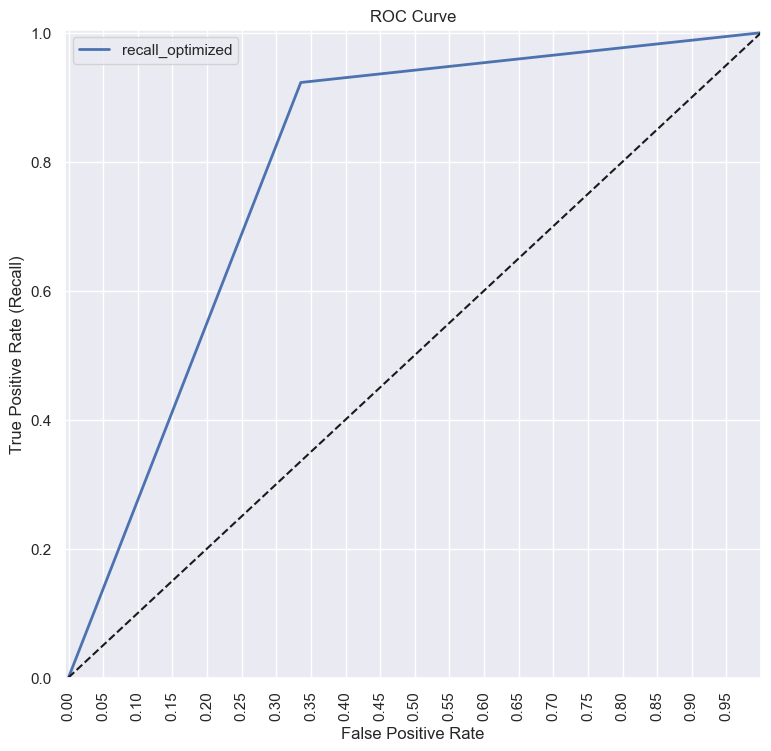

In [89]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypred_x)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [90]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypred_x)

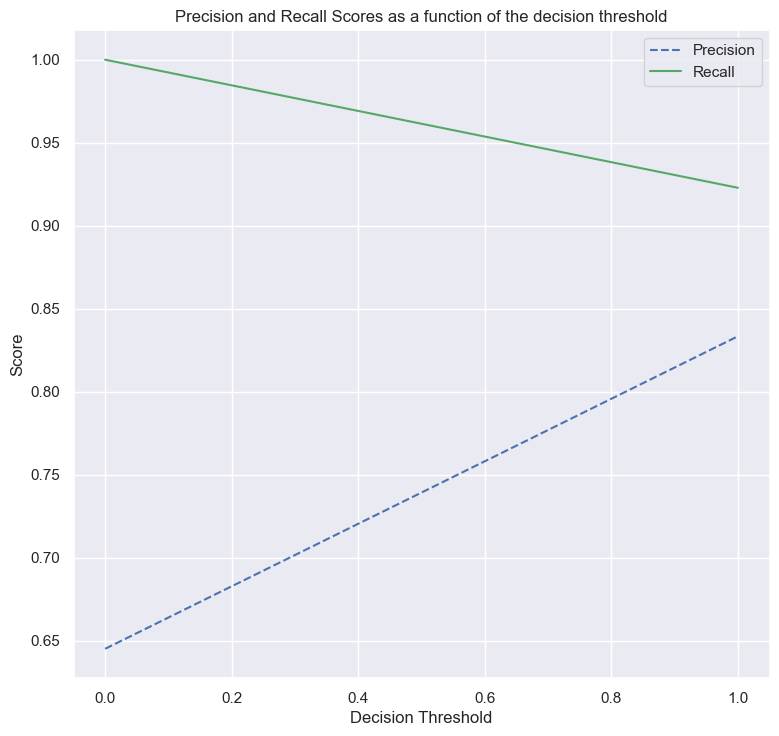

In [91]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

In [92]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('XGBoost_model.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using XGBoost model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 68.26%
The number of startup which predicted success using XGBoost model are 630 out of 923 startups
Score difference between prediction and real percentage is 3.58 %
It's about 33 startups that supposed to be failed but predicted success by the model


## Decision Tree Model

In [93]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('DecisionTree.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using Decision Tree model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 65.44%
The number of startup which predicted success using Decision Tree model are 604 out of 923 startups
Score difference between prediction and real percentage is 0.76 %
It's about 7 startups that supposed to be failed but predicted success by the model


## Logistic Regression Model

In [94]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using Logistic Regression model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 75.51%
The number of startup which predicted success using Logistic Regression model are 697 out of 923 startups
Score difference between prediction and real percentage is 10.83 %
It's about 100 startups that supposed to be failed but predicted success by the model


## KNN Model

In [95]:
data_test_ori = pd.read_csv("startup data.csv")
loaded_model = pickle.load(open('KNN_model.pkl', 'rb'))
prediction = loaded_model.predict(x)
data_test_ori['prediction'] = prediction
data_test_ori['success'] = np.where(data_test_ori['prediction']==1,'success','fail')
success_startup = data_test_ori[data_test_ori['success']=='success']
percent_predict = round(((len(success_startup))/(len(data_test_ori)))*100,2)
percent_real = round((len(acquired)/len(data))*100,2)
score_diff = abs(percent_predict-percent_real)
num_diff = round((round(score_diff,2)/100)*len(data_test_ori))
print('The percentage of successfull startup is ' + str(percent_predict) + '%')
print('The number of startup which predicted success using K-Nearest Neighbors model are', str(len(success_startup)),'out of', str(len(data_test_ori)), 'startups')
print('Score difference between prediction and real percentage is', str(round(score_diff,2)), '%')
print("It's about", str(num_diff),'startups that supposed to be failed but predicted success by the model')

The percentage of successfull startup is 69.01%
The number of startup which predicted success using K-Nearest Neighbors model are 637 out of 923 startups
Score difference between prediction and real percentage is 4.33 %
It's about 40 startups that supposed to be failed but predicted success by the model
